# Deep Neural Network for Exoplanet Discovery Method Classification
## Identifying Patterns in Exoplanet Characteristics to Determine Discovery Methods

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import optuna as opt

/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
# data preprocessed in another jupytr nb 

composite_preprocessed = pd.read_csv('Composite_preprocessed_NO_MV_BALANCED.csv')
composite_preprocessed.head()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year,Detected by Transits
0,3.094076,-0.666894,0.0,2.424559,1.234306,-0.145901,-0.624689,0.613405,1.731519,-0.261600,-0.012466,-0.044364,0,0,2007,0
1,-0.256668,-0.666894,0.0,1.186720,-0.283545,1.148661,-0.992906,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2009,0
2,-0.256668,-0.666894,0.0,-0.877523,-0.306068,0.308947,-2.327878,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2008,0
3,-0.256668,0.216988,0.0,1.382856,-0.669803,0.872499,-0.152934,0.613405,3.735304,0.591749,-0.012466,-0.044364,0,0,2002,0
4,6.444820,-0.666894,0.0,0.261241,-0.531444,1.023143,0.855489,0.613405,3.735304,2.298449,-0.012466,-0.044364,0,0,1996,0


### 2 possible results ; Either the exoplanet was discovered by transits (1) or it wasn't (0) ; binary classification
### so we have 1 neuron in the output layer  
### We will use the features from the XGBoost refined features model 
### This ensures consistency, reduces complexity, and leverages the feature selection process that has already been validated with my refined features XGBoost model
### This would also allow for a fair comparison between models

## Remove unimportant features

In [3]:
remove = ['Number of Radial Velocity Time Series',
          'Number of Stellar Spectra Measurements',
          'Controversial Flag',
          'Circumbinary Flag',
          'Number of Moons']

composite_unnecessary_removed = composite_preprocessed.drop(remove, axis=1)

## Train Test Split

In [4]:
# we are trying to predict whether an exoplanet has been detected by transits (0 or 1)
# target variable is if the exoplanet was discovered by transits

targets = composite_unnecessary_removed['Detected by Transits']

# training features are all variables except the targets

features = composite_unnecessary_removed.drop(['Detected by Transits'], axis=1)

## Observe Feature Correlations

In [5]:
features.corr()

,Number of Stars,Number of Planets,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Discovery Year
Number of Stars,1.000000,0.109074,-0.044988,0.104236,-0.087528,-0.069450,0.057734,-0.003200,-0.002096,-0.147575
Number of Planets,0.109074,1.000000,-0.055511,0.008589,0.026680,-0.023926,-0.002505,0.057797,0.076409,-0.072274
Galactic Latitude [deg],-0.044988,-0.055511,1.000000,-0.019213,0.463063,0.174632,-0.090369,-0.025691,-0.008918,0.031820
Galactic Longitude [deg],0.104236,0.008589,-0.019213,1.000000,-0.657044,-0.408779,0.131333,-0.008283,-0.026088,-0.106558
Ecliptic Latitude [deg],-0.087528,0.026680,0.463063,-0.657044,1.000000,0.498442,-0.222283,-0.006864,0.025212,0.081113
Ecliptic Longitude [deg],-0.069450,-0.023926,0.174632,-0.408779,0.498442,1.000000,-0.119612,0.013811,0.031078,0.058041
Number of Photometry Time Series,0.057734,-0.002505,-0.090369,0.131333,-0.222283,-0.119612,1.000000,-0.004172,-0.014848,-0.252983
Number of Emission Spectroscopy Measurements,-0.003200,0.057797,-0.025691,-0.008283,-0.006864,0.013811,-0.004172,1.000000,-0.000553,0.000791
Number of Transmission Spectroscopy Measurements,-0.002096,0.076409,-0.008918,-0.026088,0.025212,0.031078,-0.014848,-0.000553,1.000000,-0.015425
Discovery Year,-0.147575,-0.072274,0.031820,-0.106558,0.081113,0.058041,-0.252983,0.000791,-0.015425,1.000000


### Moderate correlation between Ecliptic Longtiude aand Ecliptic Latitude

# Random seed for reproducability

In [6]:
import random

def set_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_random_seed(42)

## Split data

In [7]:
# Splitting dataset into training, testing and validation addresses overfitting
# shuffling is necessary to remove dependencies that come from order of data


# 80:10:10 split ; Training ; Validation ; Testing
# so we split twice; once into 80:20, then 50:50 (so 50% of the designated testing portion is for validation)

# first split
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(features, targets, test_size = 0.2, random_state = 42, shuffle=True)

# second split
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42, shuffle=True)

# tensorflow models expect data in the form of a np array; NOT a pd dataframe 
# so we have to convert

def conv_nparr(df):
    return np.array(df)

data_splits = [x_train, x_val, x_test, y_train, y_val, y_test]

# list comprehension to transform all the dfs into nparr
x_train_nparr, x_val_nparr, x_test_nparr, y_train_nparr, y_val_nparr, y_test_nparr = [conv_nparr(split) for split in data_splits]

## DNN Configuration

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# learning rate scheduler; LR is reduced when it stops improving 
from tensorflow.keras.callbacks import ReduceLROnPlateau

# we use optuna for hyperparameter optimization
from optuna.integration import TFKerasPruningCallback

# k cross validation to ensure consistent model performance and is not dependent on a single train-test split
# robustness, generalizability, and assists in hyperparameter tuning
from sklearn.model_selection import KFold

### Create DNN

In [9]:
# Initializes a Sequential Model (linear stack of layers)
# Simplest way to build a model in Keras, where you can just keep adding layers sequentially

input_size = x_train.shape[1] # 10 input features in our data 
# hidden_layer_size = 50 # start off with 50 neurons per hidden layer
output_size = 1 # because 2 possible classifications denoted by 0 and 1 in a single output; DNN calculates probability the exoplanet is 0 or 1 and the higher probability is the output 

# dropout_rate = 0.05 # dropout rate we will use in the model as a measure to prevent overfitting

def create_dnn(trial):

    # since we use optuna, we have to toss in the values we want it to test during the optimization process

    # units = neurons in the hidden later, 32 to 512 jumping 32 at a time 
    units = trial.suggest_int('units', 10, 100, step=5)

    # dropout rate is self explanatory
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.5, step=0.05)

    # define our learning rate which impacts the final performance of our model, optimal LR is very beneficial in finding the right patterns
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True) # Log scale is better search 
    
    dnn_model = Sequential([
    # input layer for the input data; 10 features so 10 inputs for the first dense layer 
    # in a dense layer, each feature becomes an input to the next layer, which consists of neurons
    # the line below defines the input layer and creates the first dense layer consisting of 50 neurons
    # we use Rectified Linear Unit (ReLU) as the activation function because ReLU helps mitigate the vanishing gradient problem
# and allows the model to learn complex paterns
    tf.keras.layers.Dense(units, activation='relu', input_shape = (input_size,)),

# add a dropout layer with dropout rate of 0.1 
# This essentially just means 10% of the neurons will be randomly set to 0 during training
# Dropout is a regularization technique used to prevent overfitting 
# This helps prevent the model from overfitting by randomly dropping neurons during training
    tf.keras.layers.Dropout(dropout_rate),
    
# we only use 1 hidden layer of neurons because 2 lowers validation accuracy;
    
    # output layer with 1 neuron for binary classification
    tf.keras.layers.Dense(output_size, activation='sigmoid')
    ])
# next, choose the optimizer and loss function
# adam is usually the most optimal
# loss will be binary_crossentropy for binary classification
# the metric we care about is accuracy
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    dnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return dnn_model

def objective(trial):

    # define kfold cross-validation
    # data is split into 5 folds; each fold is used once as a validatiton set while the other 4 are for training
    # data is randomly shuffled with the True boolean before being split into folds
    
    kfold= KFold(n_splits=5, shuffle=True, random_state=42)

    # store validation accuracies in a list
    
    val_accuracies = []

    # cross validation loop 
    # loop iterates each of the 5 folds and creates train and validatiton splits for each iteration
    for train_index, val_index in kfold.split(x_train_nparr):
        x_train_fold, x_val_fold = x_train_nparr[train_index], x_train_nparr[val_index]
        y_train_fold, y_val_fold = y_train_nparr[train_index], y_train_nparr[val_index]

    
        model = create_dnn(trial)
    
    
        # suggest number of epochs and batch size
        epochs = trial.suggest_int('epochs', 5, 50, step=5)
        batch_size = trial.suggest_int('batch_size', 5,30,step=5)
    
    
        # learning rate scheduler parameters
        patience = trial.suggest_int('patience', 2, 10, step=1)
        factor = trial.suggest_float('factor', 0.1, 0.5, step=0.1)
    
    
        # Reduce LR on plateau LR scheduler
        lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', patience=patience, factor=factor, min_lr=1e-7)
        
        training = model.fit(
                x_train_nparr, 
                y_train_nparr, 
                epochs=epochs, 
                batch_size=batch_size, 
                validation_data=(x_val_nparr, y_val_nparr), 
                callbacks=[TFKerasPruningCallback(trial, 'val_accuracy'), lr_scheduler], 
                verbose=2
        )
        val_accuracy = max(training.history['val_accuracy'])

        # stores val accuracy for the current fold
        val_accuracies.append(val_accuracy)

    # after the loop we return the average val_accuracy across all folds to evaluate the effectivenes of the hyperparameters
    return np.mean(val_accuracies)
    
# create a study and optimize the objective function
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=200)


(f'Best trial: {study.best_trial.value}', f'Best hyperparameters: {study.best_trial.params}')


[I 2024-08-07 21:26:26,680] A new study created in memory with name: no-name-12af9d59-9eda-44be-b7ef-281d60b1bb7c
2024-08-07 21:26:26.718451: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 21:26:26.719525: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 4s - loss: 207.7560 - accuracy: 0.5010 - val_loss: 150.9292 - val_accuracy: 0.5078
Epoch 2/5
5148/5148 - 3s - loss: 130.8034 - accuracy: 0.4874 - val_loss: 68.7129 - val_accuracy: 0.5078
Epoch 3/5
5148/5148 - 2s - loss: 88.2945 - accuracy: 0.5080 - val_loss: 27.3035 - val_accuracy: 0.5078
Epoch 4/5
5148/5148 - 2s - loss: 84.1831 - accuracy: 0.4951 - val_loss: 11.5796 - val_accuracy: 0.5078
Epoch 5/5
5148/5148 - 2s - loss: 79.5459 - accuracy: 0.4955 - val_loss: 7.5419 - val_accuracy: 0.5078
Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 3s - loss: 82.6062 - accuracy: 0.4981 - val_loss: 32.2839 - val_accuracy: 0.5078


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Epoch 2/5
5148/5148 - 2s - loss: 59.6275 - accuracy: 0.5031 - val_loss: 6.3034 - val_accuracy: 0.5078


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


Epoch 3/5
5148/5148 - 2s - loss: 55.6999 - accuracy: 0.5033 - val_loss: 2.6211 - val_accuracy: 0.5078


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


Epoch 4/5
5148/5148 - 2s - loss: 53.4079 - accuracy: 0.4938 - val_loss: 1.3581 - val_accuracy: 0.5078


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


Epoch 5/5
5148/5148 - 2s - loss: 50.9128 - accuracy: 0.5134 - val_loss: 0.7867 - val_accuracy: 0.4922


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step


Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 3s - loss: 102.6038 - accuracy: 0.4876 - val_loss: 33.8560 - val_accuracy: 0.4922
Epoch 2/5
5148/5148 - 2s - loss: 81.0151 - accuracy: 0.4971 - val_loss: 4.3849 - val_accuracy: 0.4922
Epoch 3/5
5148/5148 - 3s - loss: 79.8464 - accuracy: 0.4920 - val_loss: 3.7774 - val_accuracy: 0.5078
Epoch 4/5
5148/5148 - 4s - loss: 75.3665 - accuracy: 0.5045 - val_loss: 1.1272 - val_accuracy: 0.5062
Epoch 5/5
5148/5148 - 3s - loss: 72.4403 - accuracy: 0.5008 - val_loss: 1.1098 - val_accuracy: 0.5062
Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 3s - loss: 113.4176 - accuracy: 0.5014 - val_loss: 43.8922 - val_accuracy: 0.5078
Epoch 2/5
5148/5148 - 3s - loss: 91.7441 - accuracy: 0.4971 - val_loss: 10.8058 - val_accuracy: 0.5078
Epoch 3/5
5148/5148 - 3s - loss: 84.3746 - accuracy: 0.5068 - val_loss: 5.3698 - val_accuracy: 0.5078
Epoch 4/5
5148/5148 - 2s - loss: 83.9738 - accuracy: 0.4959 - val_loss: 1.0478 - val_

[I 2024-08-07 21:27:37,889] Trial 0 finished with value: 0.5096273422241211 and parameters: {'units': 50, 'dropout': 0.25, 'learning_rate': 1.593352116249386e-05, 'epochs': 5, 'batch_size': 5, 'patience': 8, 'factor': 0.2}. Best is trial 0 with value: 0.5096273422241211.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 2s - loss: 20.7020 - accuracy: 0.5185 - val_loss: 0.6355 - val_accuracy: 0.6056
Epoch 2/50
5148/5148 - 1s - loss: 0.8214 - accuracy: 0.5260 - val_loss: 0.7004 - val_accuracy: 0.4922
Epoch 3/50
5148/5148 - 1s - loss: 0.6662 - accuracy: 0.6121 - val_loss: 0.5695 - val_accuracy: 0.7671
Epoch 4/50
5148/5148 - 1s - loss: 0.6043 - accuracy: 0.6700 - val_loss: 0.5656 - val_accuracy: 0.7252
Epoch 5/50
5148/5148 - 1s - loss: 0.5887 - accuracy: 0.7053 - val_loss: 0.5979 - val_accuracy: 0.7422
Epoch 6/50
5148/5148 - 1s - loss: 0.6282 - accuracy: 0.6414 - val_loss: 0.6368 - val_accuracy: 0.8494
Epoch 7/50
5148/5148 - 1s - loss: 0.6268 - accuracy: 0.6449 - val_loss: 0.6923 - val_accuracy: 0.5093
Epoch 8/50
5148/5148 - 2s - loss: 0.6791 - accuracy: 0.5400 - val_loss: 0.6767 - val_accuracy: 0.5776
Epoch 9/50
5148/5148 - 2s - loss: 0.6878 - accuracy: 0.5212 - val_loss: 0.5942 - val_accuracy: 0.8121
Epoch 10/50
5148/5148 - 1s - loss:

/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


Epoch 7/50
5148/5148 - 1s - loss: 0.5769 - accuracy: 0.7053 - val_loss: 0.6053 - val_accuracy: 0.6630


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step


Epoch 8/50
5148/5148 - 1s - loss: 0.5835 - accuracy: 0.6999 - val_loss: 0.6149 - val_accuracy: 0.7112


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


Epoch 9/50
5148/5148 - 1s - loss: 0.6468 - accuracy: 0.5998 - val_loss: 0.6775 - val_accuracy: 0.5124


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


Epoch 10/50
5148/5148 - 1s - loss: 0.6589 - accuracy: 0.5670 - val_loss: 0.5805 - val_accuracy: 0.7748


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


Epoch 11/50
5148/5148 - 1s - loss: 0.6815 - accuracy: 0.5258 - val_loss: 0.6897 - val_accuracy: 0.4922


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


Epoch 12/50
5148/5148 - 1s - loss: 0.6119 - accuracy: 0.6575 - val_loss: 0.6824 - val_accuracy: 0.5652


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


Epoch 13/50
5148/5148 - 1s - loss: 0.6210 - accuracy: 0.6523 - val_loss: 0.5324 - val_accuracy: 0.8571


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step


Epoch 14/50
5148/5148 - 2s - loss: 0.5836 - accuracy: 0.7096 - val_loss: 0.4978 - val_accuracy: 0.8447


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


Epoch 15/50
5148/5148 - 1s - loss: 0.5686 - accuracy: 0.7211 - val_loss: 0.4858 - val_accuracy: 0.8447


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step


Epoch 16/50
5148/5148 - 2s - loss: 0.5584 - accuracy: 0.7335 - val_loss: 0.4839 - val_accuracy: 0.8478


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


Epoch 17/50
5148/5148 - 1s - loss: 0.5680 - accuracy: 0.7141 - val_loss: 0.5054 - val_accuracy: 0.8339


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step


Epoch 18/50
5148/5148 - 1s - loss: 0.5601 - accuracy: 0.7312 - val_loss: 0.4879 - val_accuracy: 0.8525


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


Epoch 19/50
5148/5148 - 2s - loss: 0.5703 - accuracy: 0.7073 - val_loss: 0.5174 - val_accuracy: 0.7702


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


Epoch 20/50
5148/5148 - 1s - loss: 0.5659 - accuracy: 0.7205 - val_loss: 0.4561 - val_accuracy: 0.8556


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


Epoch 21/50
5148/5148 - 2s - loss: 0.5436 - accuracy: 0.7403 - val_loss: 0.4701 - val_accuracy: 0.8540


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


Epoch 22/50
5148/5148 - 1s - loss: 0.5346 - accuracy: 0.7463 - val_loss: 0.4563 - val_accuracy: 0.8556


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


Epoch 23/50
5148/5148 - 2s - loss: 0.5349 - accuracy: 0.7475 - val_loss: 0.5018 - val_accuracy: 0.7686


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step


Epoch 24/50
5148/5148 - 2s - loss: 0.5400 - accuracy: 0.7368 - val_loss: 0.4517 - val_accuracy: 0.8665


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


Epoch 25/50
5148/5148 - 1s - loss: 0.5421 - accuracy: 0.7366 - val_loss: 0.5335 - val_accuracy: 0.7484


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


Epoch 26/50
5148/5148 - 1s - loss: 0.5399 - accuracy: 0.7383 - val_loss: 0.4391 - val_accuracy: 0.8696


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


Epoch 27/50
5148/5148 - 1s - loss: 0.5358 - accuracy: 0.7405 - val_loss: 0.5103 - val_accuracy: 0.7640


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step


Epoch 28/50
5148/5148 - 1s - loss: 0.5305 - accuracy: 0.7422 - val_loss: 0.4358 - val_accuracy: 0.8711


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


Epoch 29/50
5148/5148 - 1s - loss: 0.5410 - accuracy: 0.7306 - val_loss: 0.4821 - val_accuracy: 0.8199


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step


Epoch 30/50
5148/5148 - 1s - loss: 0.5219 - accuracy: 0.7564 - val_loss: 0.4312 - val_accuracy: 0.8665


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


Epoch 31/50
5148/5148 - 1s - loss: 0.5418 - accuracy: 0.7341 - val_loss: 0.5716 - val_accuracy: 0.7189


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


Epoch 32/50
5148/5148 - 1s - loss: 0.5357 - accuracy: 0.7350 - val_loss: 0.4459 - val_accuracy: 0.8307


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


Epoch 33/50
5148/5148 - 1s - loss: 0.5305 - accuracy: 0.7432 - val_loss: 0.4341 - val_accuracy: 0.8525


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step


Epoch 34/50
5148/5148 - 1s - loss: 0.5315 - accuracy: 0.7380 - val_loss: 0.4287 - val_accuracy: 0.8680


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


Epoch 35/50
5148/5148 - 1s - loss: 0.5339 - accuracy: 0.7360 - val_loss: 0.4402 - val_accuracy: 0.8323


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step


Epoch 36/50
5148/5148 - 1s - loss: 0.5252 - accuracy: 0.7415 - val_loss: 0.4295 - val_accuracy: 0.8665


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


Epoch 37/50
5148/5148 - 1s - loss: 0.5287 - accuracy: 0.7362 - val_loss: 0.4773 - val_accuracy: 0.8106


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


Epoch 38/50
5148/5148 - 1s - loss: 0.5192 - accuracy: 0.7473 - val_loss: 0.4534 - val_accuracy: 0.8385


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


Epoch 39/50
5148/5148 - 1s - loss: 0.5296 - accuracy: 0.7391 - val_loss: 0.4253 - val_accuracy: 0.8711


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step


Epoch 40/50
5148/5148 - 1s - loss: 0.5232 - accuracy: 0.7436 - val_loss: 0.4484 - val_accuracy: 0.8339


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


Epoch 41/50
5148/5148 - 1s - loss: 0.5257 - accuracy: 0.7416 - val_loss: 0.4434 - val_accuracy: 0.8370


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step


Epoch 42/50
5148/5148 - 1s - loss: 0.5265 - accuracy: 0.7438 - val_loss: 0.4248 - val_accuracy: 0.8649


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


Epoch 43/50
5148/5148 - 1s - loss: 0.5175 - accuracy: 0.7440 - val_loss: 0.4228 - val_accuracy: 0.8680


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


Epoch 44/50
5148/5148 - 1s - loss: 0.5236 - accuracy: 0.7422 - val_loss: 0.4243 - val_accuracy: 0.8602


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


Epoch 45/50
5148/5148 - 1s - loss: 0.5286 - accuracy: 0.7385 - val_loss: 0.4292 - val_accuracy: 0.8339


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step


Epoch 46/50
5148/5148 - 1s - loss: 0.5244 - accuracy: 0.7426 - val_loss: 0.4369 - val_accuracy: 0.8354


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


Epoch 47/50
5148/5148 - 1s - loss: 0.5250 - accuracy: 0.7409 - val_loss: 0.4380 - val_accuracy: 0.8370


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step


Epoch 48/50
5148/5148 - 1s - loss: 0.5097 - accuracy: 0.7539 - val_loss: 0.4598 - val_accuracy: 0.8339


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


Epoch 49/50
5148/5148 - 1s - loss: 0.5172 - accuracy: 0.7490 - val_loss: 0.4225 - val_accuracy: 0.8339


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


Epoch 50/50
5148/5148 - 1s - loss: 0.5164 - accuracy: 0.7469 - val_loss: 0.4240 - val_accuracy: 0.8323


/Users/kevin/anaconda3/envs/tf_env/lib/python3.7/site-packages/optuna/trial/_trial.py:495: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 2s - loss: 19.9989 - accuracy: 0.5433 - val_loss: 0.7664 - val_accuracy: 0.5078
Epoch 2/50
5148/5148 - 1s - loss: 0.7011 - accuracy: 0.5789 - val_loss: 0.7515 - val_accuracy: 0.4922
Epoch 3/50
5148/5148 - 1s - loss: 0.7023 - accuracy: 0.5664 - val_loss: 0.6721 - val_accuracy: 0.4922
Epoch 4/50
5148/5148 - 2s - loss: 0.6536 - accuracy: 0.6134 - val_loss: 0.6494 - val_accuracy: 0.6320
Epoch 5/50
5148/5148 - 1s - loss: 0.6066 - accuracy: 0.6721 - val_loss: 0.6579 - val_accuracy: 0.6413
Epoch 6/50
5148/5148 - 1s - loss: 0.6343 - accuracy: 0.6296 - val_loss: 0.6733 - val_accuracy: 0.5854
Epoch 7/50
5148/5148 - 2s - loss: 0.5853 - accuracy: 0.7038 - val_loss: 0.5626 - val_accuracy: 0.7593
Epoch 8/50
5148/5148 - 2s - loss: 0.5881 - accuracy: 0.7007 - val_loss: 0.5238 - val_accuracy: 0.8385
Epoch 9/50
5148/5148 - 1s - loss: 0.5978 - accuracy: 0.6911 - val_loss: 0.5739 - val_accuracy: 0.7422
Epoch 10/50
5148/5148 - 1s - loss:

[I 2024-08-07 21:33:08,121] Trial 1 finished with value: 0.8692547082901001 and parameters: {'units': 60, 'dropout': 0.35000000000000003, 'learning_rate': 0.005993902800717084, 'epochs': 50, 'batch_size': 20, 'patience': 7, 'factor': 0.5}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 2s - loss: 81.8407 - accuracy: 0.5035 - val_loss: 4.2724 - val_accuracy: 0.4922
Epoch 2/5
5148/5148 - 1s - loss: 58.8445 - accuracy: 0.5173 - val_loss: 3.6212 - val_accuracy: 0.5078
Epoch 3/5
5148/5148 - 1s - loss: 55.3373 - accuracy: 0.5111 - val_loss: 2.2474 - val_accuracy: 0.5109
Epoch 4/5
5148/5148 - 1s - loss: 55.6436 - accuracy: 0.4963 - val_loss: 0.8043 - val_accuracy: 0.6661
Epoch 5/5
5148/5148 - 1s - loss: 50.7595 - accuracy: 0.4963 - val_loss: 0.7579 - val_accuracy: 0.6786
Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 2s - loss: 73.3466 - accuracy: 0.4932 - val_loss: 2.6790 - val_accuracy: 0.4922
Epoch 2/5
5148/5148 - 1s - loss: 47.9462 - accuracy: 0.4926 - val_loss: 3.3866 - val_accuracy: 0.4922
Epoch 3/5
5148/5148 - 1s - loss: 44.2615 - accuracy: 0.5084 - val_loss: 0.7000 - val_accuracy: 0.5668
Epoch 4/5
5148/5148 - 6s - loss: 40.0533 - accuracy: 0.5212 - val_loss: 0.8371 - val_accur

[I 2024-08-07 21:33:41,887] Trial 2 finished with value: 0.694720447063446 and parameters: {'units': 65, 'dropout': 0.15000000000000002, 'learning_rate': 0.00012574542285984544, 'epochs': 5, 'batch_size': 20, 'patience': 8, 'factor': 0.1}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/15
5148/5148 - 3s - loss: 397.9292 - accuracy: 0.4986 - val_loss: 203.1567 - val_accuracy: 0.4922
Epoch 2/15
5148/5148 - 2s - loss: 129.6117 - accuracy: 0.5043 - val_loss: 11.8029 - val_accuracy: 0.4922
Epoch 3/15
5148/5148 - 3s - loss: 93.3887 - accuracy: 0.5045 - val_loss: 0.4812 - val_accuracy: 0.7376
Epoch 4/15
5148/5148 - 4s - loss: 79.2768 - accuracy: 0.5060 - val_loss: 2.1792 - val_accuracy: 0.5124
Epoch 5/15
5148/5148 - 5s - loss: 69.4919 - accuracy: 0.5126 - val_loss: 1.9680 - val_accuracy: 0.5124
Epoch 6/15
5148/5148 - 5s - loss: 59.1588 - accuracy: 0.5072 - val_loss: 7.1945 - val_accuracy: 0.4922
Epoch 7/15
5148/5148 - 5s - loss: 50.1394 - accuracy: 0.5062 - val_loss: 0.4864 - val_accuracy: 0.7640
Epoch 8/15
5148/5148 - 5s - loss: 41.1515 - accuracy: 0.5037 - val_loss: 1.3531 - val_accuracy: 0.5947
Epoch 9/15
5148/5148 - 6s - loss: 32.3115 - accuracy: 0.4953 - val_loss: 0.8248 - val_accuracy: 0.6134
Epoch 10/15
5148/5148

[I 2024-08-07 21:40:32,102] Trial 3 finished with value: 0.8257763981819153 and parameters: {'units': 35, 'dropout': 0.35000000000000003, 'learning_rate': 6.385629676439278e-05, 'epochs': 15, 'batch_size': 5, 'patience': 5, 'factor': 0.1}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 2s - loss: 3.0153 - accuracy: 0.6909 - val_loss: 1.4304 - val_accuracy: 0.5202
Epoch 2/45
5148/5148 - 1s - loss: 0.9665 - accuracy: 0.7510 - val_loss: 0.9452 - val_accuracy: 0.7205
Epoch 3/45
5148/5148 - 1s - loss: 1.0136 - accuracy: 0.7661 - val_loss: 1.2243 - val_accuracy: 0.7065
Epoch 4/45
5148/5148 - 1s - loss: 1.0751 - accuracy: 0.7652 - val_loss: 1.5090 - val_accuracy: 0.5994
Epoch 5/45
5148/5148 - 1s - loss: 1.6079 - accuracy: 0.7339 - val_loss: 6.9119 - val_accuracy: 0.4922
Epoch 6/45
5148/5148 - 2s - loss: 1.1593 - accuracy: 0.7846 - val_loss: 1.2883 - val_accuracy: 0.7469
Epoch 7/45
5148/5148 - 2s - loss: 1.3715 - accuracy: 0.7791 - val_loss: 1.5329 - val_accuracy: 0.7283
Epoch 8/45
5148/5148 - 2s - loss: 0.8190 - accuracy: 0.8355 - val_loss: 1.4726 - val_accuracy: 0.6227
Epoch 9/45
5148/5148 - 2s - loss: 1.0583 - accuracy: 0.7887 - val_loss: 1.0240 - val_accuracy: 0.7624
Epoch 10/45
5148/5148 - 1s - loss: 

[I 2024-08-07 21:45:25,446] Trial 4 finished with value: 0.865217387676239 and parameters: {'units': 25, 'dropout': 0.0, 'learning_rate': 0.004713485953166379, 'epochs': 45, 'batch_size': 20, 'patience': 10, 'factor': 0.5}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/15


[I 2024-08-07 21:45:28,154] Trial 5 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 21:45:31,031] Trial 6 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 21:45:33,402] Trial 7 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 3s - loss: 419.5196 - accuracy: 0.5043 - val_loss: 405.8313 - val_accuracy: 0.5078
Epoch 2/5
5148/5148 - 2s - loss: 397.2800 - accuracy: 0.5014 - val_loss: 382.3069 - val_accuracy: 0.5078
Epoch 3/5


[I 2024-08-07 21:45:40,745] Trial 8 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/15


[I 2024-08-07 21:45:42,778] Trial 9 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 2s - loss: 14.1445 - accuracy: 0.5144 - val_loss: 0.7241 - val_accuracy: 0.5078
Epoch 2/50
5148/5148 - 1s - loss: 0.6958 - accuracy: 0.5478 - val_loss: 0.6482 - val_accuracy: 0.4984
Epoch 3/50


[I 2024-08-07 21:45:45,535] Trial 10 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 2s - loss: 2.5659 - accuracy: 0.6445 - val_loss: 0.9608 - val_accuracy: 0.5854
Epoch 2/50
5148/5148 - 1s - loss: 0.5547 - accuracy: 0.7492 - val_loss: 0.4699 - val_accuracy: 0.8416
Epoch 3/50
5148/5148 - 1s - loss: 0.5500 - accuracy: 0.7721 - val_loss: 0.5237 - val_accuracy: 0.7314
Epoch 4/50
5148/5148 - 1s - loss: 0.4703 - accuracy: 0.8061 - val_loss: 0.4648 - val_accuracy: 0.8634
Epoch 5/50
5148/5148 - 1s - loss: 0.4788 - accuracy: 0.8102 - val_loss: 0.4259 - val_accuracy: 0.8587
Epoch 6/50
5148/5148 - 1s - loss: 0.4597 - accuracy: 0.8106 - val_loss: 0.5351 - val_accuracy: 0.8634
Epoch 7/50
5148/5148 - 1s - loss: 0.4222 - accuracy: 0.8293 - val_loss: 0.6735 - val_accuracy: 0.7127
Epoch 8/50
5148/5148 - 1s - loss: 0.4145 - accuracy: 0.8359 - val_loss: 0.5807 - val_accuracy: 0.7267
Epoch 9/50
5148/5148 - 1s - loss: 0.4022 - accuracy: 0.8306 - val_loss: 0.4075 - val_accuracy: 0.8556
Epoch 10/50
5148/5148 - 1s - loss: 

[I 2024-08-07 21:50:15,995] Trial 11 finished with value: 0.8642857670783997 and parameters: {'units': 10, 'dropout': 0.0, 'learning_rate': 0.009997009950513665, 'epochs': 50, 'batch_size': 25, 'patience': 10, 'factor': 0.4}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 3s - loss: 17.3911 - accuracy: 0.5260 - val_loss: 0.6603 - val_accuracy: 0.5543
Epoch 2/40
5148/5148 - 1s - loss: 0.7709 - accuracy: 0.5425 - val_loss: 0.7511 - val_accuracy: 0.4922
Epoch 3/40


[I 2024-08-07 21:50:21,821] Trial 12 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 2s - loss: 6.3861 - accuracy: 0.6385 - val_loss: 1.2396 - val_accuracy: 0.5807
Epoch 2/30
5148/5148 - 1s - loss: 0.6495 - accuracy: 0.7432 - val_loss: 0.9692 - val_accuracy: 0.6599
Epoch 3/30
5148/5148 - 1s - loss: 0.6739 - accuracy: 0.7549 - val_loss: 0.4752 - val_accuracy: 0.7919
Epoch 4/30
5148/5148 - 1s - loss: 0.5623 - accuracy: 0.7955 - val_loss: 0.7416 - val_accuracy: 0.7391
Epoch 5/30
5148/5148 - 1s - loss: 0.7677 - accuracy: 0.7525 - val_loss: 0.7073 - val_accuracy: 0.8634
Epoch 6/30
5148/5148 - 1s - loss: 0.7602 - accuracy: 0.7727 - val_loss: 0.5122 - val_accuracy: 0.8587
Epoch 7/30
5148/5148 - 1s - loss: 0.5691 - accuracy: 0.8162 - val_loss: 0.4633 - val_accuracy: 0.8587
Epoch 8/30
5148/5148 - 1s - loss: 0.5784 - accuracy: 0.8048 - val_loss: 0.6777 - val_accuracy: 0.8634
Epoch 9/30
5148/5148 - 1s - loss: 0.5591 - accuracy: 0.8172 - val_loss: 0.7435 - val_accuracy: 0.7484
Epoch 10/30
5148/5148 - 1s - loss: 

[I 2024-08-07 21:53:01,019] Trial 13 finished with value: 0.8645962476730347 and parameters: {'units': 75, 'dropout': 0.0, 'learning_rate': 0.002176177541944633, 'epochs': 30, 'batch_size': 25, 'patience': 8, 'factor': 0.30000000000000004}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 3s - loss: 35.0625 - accuracy: 0.5286 - val_loss: 0.5847 - val_accuracy: 0.7717
Epoch 2/45
5148/5148 - 2s - loss: 0.8193 - accuracy: 0.5447 - val_loss: 0.7432 - val_accuracy: 0.4922
Epoch 3/45
5148/5148 - 2s - loss: 0.7591 - accuracy: 0.5301 - val_loss: 0.6756 - val_accuracy: 0.7220
Epoch 4/45
5148/5148 - 1s - loss: 0.6997 - accuracy: 0.5666 - val_loss: 0.6467 - val_accuracy: 0.6475
Epoch 5/45
5148/5148 - 2s - loss: 0.7052 - accuracy: 0.5657 - val_loss: 0.6049 - val_accuracy: 0.7686
Epoch 6/45
5148/5148 - 2s - loss: 0.6400 - accuracy: 0.6228 - val_loss: 0.5930 - val_accuracy: 0.8494
Epoch 7/45
5148/5148 - 2s - loss: 0.6202 - accuracy: 0.6527 - val_loss: 0.6090 - val_accuracy: 0.7422
Epoch 8/45
5148/5148 - 1s - loss: 0.6239 - accuracy: 0.6447 - val_loss: 0.5601 - val_accuracy: 0.7422
Epoch 9/45
5148/5148 - 2s - loss: 0.6174 - accuracy: 0.6599 - val_loss: 0.5952 - val_accuracy: 0.7345
Epoch 10/45
5148/5148 - 2s - loss:

[I 2024-08-07 21:53:53,059] Trial 14 pruned. Trial was pruned at epoch 27.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 2s - loss: 49.9889 - accuracy: 0.5056 - val_loss: 0.5793 - val_accuracy: 0.7127
Epoch 2/30
5148/5148 - 1s - loss: 28.0541 - accuracy: 0.5097 - val_loss: 1.7222 - val_accuracy: 0.5435
Epoch 3/30
5148/5148 - 1s - loss: 20.4150 - accuracy: 0.5235 - val_loss: 0.6028 - val_accuracy: 0.7795
Epoch 4/30
5148/5148 - 1s - loss: 14.7495 - accuracy: 0.5389 - val_loss: 1.0463 - val_accuracy: 0.7267
Epoch 5/30
5148/5148 - 1s - loss: 9.8686 - accuracy: 0.5647 - val_loss: 0.7681 - val_accuracy: 0.7484
Epoch 6/30


[I 2024-08-07 21:53:58,174] Trial 15 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 2s - loss: 29.6447 - accuracy: 0.5449 - val_loss: 0.5164 - val_accuracy: 0.7252
Epoch 2/35
5148/5148 - 3s - loss: 0.6924 - accuracy: 0.6294 - val_loss: 0.5448 - val_accuracy: 0.8447
Epoch 3/35
5148/5148 - 5s - loss: 0.6183 - accuracy: 0.6723 - val_loss: 0.6033 - val_accuracy: 0.6351
Epoch 4/35
5148/5148 - 4s - loss: 0.5929 - accuracy: 0.6830 - val_loss: 0.5182 - val_accuracy: 0.8385
Epoch 5/35
5148/5148 - 5s - loss: 0.6291 - accuracy: 0.6354 - val_loss: 0.5946 - val_accuracy: 0.7360
Epoch 6/35


[I 2024-08-07 21:54:20,959] Trial 16 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 7s - loss: 31.4397 - accuracy: 0.6028 - val_loss: 0.4905 - val_accuracy: 0.7500
Epoch 2/50
5148/5148 - 2s - loss: 18.8011 - accuracy: 0.6453 - val_loss: 0.5713 - val_accuracy: 0.8478
Epoch 3/50
5148/5148 - 2s - loss: 14.5096 - accuracy: 0.7214 - val_loss: 0.4719 - val_accuracy: 0.8214
Epoch 4/50
5148/5148 - 1s - loss: 11.6287 - accuracy: 0.7236 - val_loss: 0.5149 - val_accuracy: 0.8463
Epoch 5/50
5148/5148 - 1s - loss: 8.9818 - accuracy: 0.7302 - val_loss: 0.5149 - val_accuracy: 0.8463
Epoch 6/50


[I 2024-08-07 21:54:35,638] Trial 17 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 2s - loss: 42.8122 - accuracy: 0.5301 - val_loss: 0.4941 - val_accuracy: 0.7438
Epoch 2/45
5148/5148 - 1s - loss: 0.6998 - accuracy: 0.6311 - val_loss: 0.5888 - val_accuracy: 0.6165
Epoch 3/45
5148/5148 - 1s - loss: 0.6026 - accuracy: 0.6904 - val_loss: 0.4843 - val_accuracy: 0.7780
Epoch 4/45
5148/5148 - 1s - loss: 0.5884 - accuracy: 0.6904 - val_loss: 0.5296 - val_accuracy: 0.7376
Epoch 5/45
5148/5148 - 1s - loss: 0.5940 - accuracy: 0.7001 - val_loss: 0.5369 - val_accuracy: 0.7329
Epoch 6/45


[I 2024-08-07 21:54:40,806] Trial 18 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 21:54:42,657] Trial 19 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 6s - loss: 111.0314 - accuracy: 0.5066 - val_loss: 0.5521 - val_accuracy: 0.7826
Epoch 2/45
5148/5148 - 2s - loss: 6.8841 - accuracy: 0.6204 - val_loss: 0.5671 - val_accuracy: 0.6599
Epoch 3/45
5148/5148 - 1s - loss: 0.5538 - accuracy: 0.7279 - val_loss: 0.5281 - val_accuracy: 0.7376
Epoch 4/45
5148/5148 - 1s - loss: 0.5494 - accuracy: 0.7259 - val_loss: 0.6198 - val_accuracy: 0.6475
Epoch 5/45
5148/5148 - 2s - loss: 0.5986 - accuracy: 0.6558 - val_loss: 0.5816 - val_accuracy: 0.7717
Epoch 6/45


[I 2024-08-07 21:54:55,845] Trial 20 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 2s - loss: 1.5214 - accuracy: 0.6702 - val_loss: 0.5922 - val_accuracy: 0.7407
Epoch 2/25
5148/5148 - 1s - loss: 0.6449 - accuracy: 0.7403 - val_loss: 0.8931 - val_accuracy: 0.6693
Epoch 3/25
5148/5148 - 1s - loss: 0.6523 - accuracy: 0.7624 - val_loss: 0.5435 - val_accuracy: 0.7314
Epoch 4/25
5148/5148 - 1s - loss: 0.5449 - accuracy: 0.7914 - val_loss: 0.6410 - val_accuracy: 0.8401
Epoch 5/25
5148/5148 - 1s - loss: 0.6859 - accuracy: 0.7650 - val_loss: 0.6049 - val_accuracy: 0.8618
Epoch 6/25
5148/5148 - 1s - loss: 0.6845 - accuracy: 0.7813 - val_loss: 0.4935 - val_accuracy: 0.8587
Epoch 7/25
5148/5148 - 1s - loss: 0.5383 - accuracy: 0.8188 - val_loss: 0.4477 - val_accuracy: 0.8354
Epoch 8/25
5148/5148 - 1s - loss: 0.5203 - accuracy: 0.8147 - val_loss: 0.6892 - val_accuracy: 0.8587
Epoch 9/25
5148/5148 - 1s - loss: 0.5363 - accuracy: 0.8174 - val_loss: 0.6595 - val_accuracy: 0.7578
Epoch 10/25
5148/5148 - 1s - loss: 

[I 2024-08-07 21:56:41,677] Trial 21 finished with value: 0.863043487071991 and parameters: {'units': 75, 'dropout': 0.0, 'learning_rate': 0.0017808096297605293, 'epochs': 25, 'batch_size': 25, 'patience': 8, 'factor': 0.30000000000000004}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 2s - loss: 14.6154 - accuracy: 0.5379 - val_loss: 1.0763 - val_accuracy: 0.8199
Epoch 2/30
5148/5148 - 1s - loss: 2.9469 - accuracy: 0.6826 - val_loss: 2.1873 - val_accuracy: 0.5124
Epoch 3/30
5148/5148 - 1s - loss: 0.8624 - accuracy: 0.7457 - val_loss: 0.4604 - val_accuracy: 0.7873
Epoch 4/30
5148/5148 - 1s - loss: 0.5283 - accuracy: 0.7813 - val_loss: 0.4661 - val_accuracy: 0.8416
Epoch 5/30
5148/5148 - 1s - loss: 0.5280 - accuracy: 0.7809 - val_loss: 0.5034 - val_accuracy: 0.8587
Epoch 6/30
5148/5148 - 1s - loss: 0.5013 - accuracy: 0.7786 - val_loss: 0.8172 - val_accuracy: 0.5311
Epoch 7/30
5148/5148 - 1s - loss: 0.4339 - accuracy: 0.8182 - val_loss: 0.4565 - val_accuracy: 0.7671
Epoch 8/30
5148/5148 - 1s - loss: 0.4196 - accuracy: 0.8314 - val_loss: 0.4426 - val_accuracy: 0.7469
Epoch 9/30
5148/5148 - 1s - loss: 0.4209 - accuracy: 0.8275 - val_loss: 0.4406 - val_accuracy: 0.8571
Epoch 10/30
5148/5148 - 1s - loss:

[I 2024-08-07 22:00:33,977] Trial 22 finished with value: 0.8680124282836914 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.005819721184669565, 'epochs': 30, 'batch_size': 25, 'patience': 8, 'factor': 0.4}. Best is trial 1 with value: 0.8692547082901001.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 2s - loss: 17.1906 - accuracy: 0.5328 - val_loss: 1.5171 - val_accuracy: 0.7112
Epoch 2/35
5148/5148 - 1s - loss: 1.7252 - accuracy: 0.6702 - val_loss: 0.5425 - val_accuracy: 0.8447
Epoch 3/35
5148/5148 - 1s - loss: 0.5312 - accuracy: 0.7702 - val_loss: 0.6271 - val_accuracy: 0.6910
Epoch 4/35
5148/5148 - 1s - loss: 0.4637 - accuracy: 0.8007 - val_loss: 0.5404 - val_accuracy: 0.8602
Epoch 5/35
5148/5148 - 1s - loss: 0.5068 - accuracy: 0.7721 - val_loss: 0.4191 - val_accuracy: 0.8494
Epoch 6/35
5148/5148 - 1s - loss: 0.4498 - accuracy: 0.8127 - val_loss: 0.5335 - val_accuracy: 0.8556
Epoch 7/35
5148/5148 - 1s - loss: 0.4393 - accuracy: 0.8100 - val_loss: 0.5975 - val_accuracy: 0.7065
Epoch 8/35
5148/5148 - 1s - loss: 0.4354 - accuracy: 0.8174 - val_loss: 0.4095 - val_accuracy: 0.8478
Epoch 9/35
5148/5148 - 1s - loss: 0.4203 - accuracy: 0.8248 - val_loss: 0.4243 - val_accuracy: 0.8385
Epoch 10/35
5148/5148 - 1s - loss:

[I 2024-08-07 22:02:46,271] Trial 23 finished with value: 0.8711179494857788 and parameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.005950059733283976, 'epochs': 35, 'batch_size': 30, 'patience': 9, 'factor': 0.4}. Best is trial 23 with value: 0.8711179494857788.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 3s - loss: 18.7446 - accuracy: 0.5552 - val_loss: 1.4307 - val_accuracy: 0.7360
Epoch 2/35
5148/5148 - 1s - loss: 1.9333 - accuracy: 0.6974 - val_loss: 0.5573 - val_accuracy: 0.8463
Epoch 3/35
5148/5148 - 1s - loss: 0.5219 - accuracy: 0.7745 - val_loss: 0.4525 - val_accuracy: 0.8137
Epoch 4/35
5148/5148 - 1s - loss: 0.4826 - accuracy: 0.7889 - val_loss: 0.4815 - val_accuracy: 0.8416
Epoch 5/35
5148/5148 - 1s - loss: 0.5098 - accuracy: 0.7704 - val_loss: 0.4500 - val_accuracy: 0.7873
Epoch 6/35
5148/5148 - 1s - loss: 0.4860 - accuracy: 0.7865 - val_loss: 0.5007 - val_accuracy: 0.8540
Epoch 7/35
5148/5148 - 1s - loss: 0.4463 - accuracy: 0.8172 - val_loss: 0.5775 - val_accuracy: 0.7065
Epoch 8/35
5148/5148 - 1s - loss: 0.4258 - accuracy: 0.8331 - val_loss: 0.4167 - val_accuracy: 0.8463
Epoch 9/35
5148/5148 - 1s - loss: 0.4244 - accuracy: 0.8294 - val_loss: 0.4430 - val_accuracy: 0.8509
Epoch 10/35
5148/5148 - 1s - loss:

[I 2024-08-07 22:05:03,300] Trial 24 finished with value: 0.8686335682868958 and parameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.007513644123232813, 'epochs': 35, 'batch_size': 30, 'patience': 7, 'factor': 0.4}. Best is trial 23 with value: 0.8711179494857788.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 1s - loss: 21.4138 - accuracy: 0.5684 - val_loss: 1.5217 - val_accuracy: 0.6102
Epoch 2/35


[I 2024-08-07 22:05:05,845] Trial 25 pruned. Trial was pruned at epoch 1.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:05:08,166] Trial 26 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 2s - loss: 35.3457 - accuracy: 0.4977 - val_loss: 0.6216 - val_accuracy: 0.7143
Epoch 2/35
5148/5148 - 0s - loss: 18.9870 - accuracy: 0.5126 - val_loss: 0.9719 - val_accuracy: 0.6630
Epoch 3/35
5148/5148 - 0s - loss: 8.2457 - accuracy: 0.5418 - val_loss: 0.7013 - val_accuracy: 0.7376
Epoch 4/35
5148/5148 - 0s - loss: 2.6989 - accuracy: 0.6138 - val_loss: 0.5692 - val_accuracy: 0.7578
Epoch 5/35
5148/5148 - 0s - loss: 0.8488 - accuracy: 0.7220 - val_loss: 0.4731 - val_accuracy: 0.8323
Epoch 6/35


[I 2024-08-07 22:05:12,432] Trial 27 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:05:16,227] Trial 28 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:05:25,660] Trial 29 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:05:28,882] Trial 30 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 17.8609 - accuracy: 0.5635 - val_loss: 2.1317 - val_accuracy: 0.7407
Epoch 2/30
5148/5148 - 1s - loss: 4.0057 - accuracy: 0.6752 - val_loss: 2.8981 - val_accuracy: 0.4984
Epoch 3/30
5148/5148 - 1s - loss: 1.2391 - accuracy: 0.7403 - val_loss: 0.5418 - val_accuracy: 0.7686
Epoch 4/30
5148/5148 - 1s - loss: 0.4684 - accuracy: 0.8067 - val_loss: 0.4242 - val_accuracy: 0.8432
Epoch 5/30
5148/5148 - 1s - loss: 0.4470 - accuracy: 0.8160 - val_loss: 0.4241 - val_accuracy: 0.8494
Epoch 6/30
5148/5148 - 1s - loss: 0.4440 - accuracy: 0.8112 - val_loss: 0.5037 - val_accuracy: 0.8587
Epoch 7/30
5148/5148 - 1s - loss: 0.4064 - accuracy: 0.8343 - val_loss: 0.4410 - val_accuracy: 0.7733
Epoch 8/30
5148/5148 - 1s - loss: 0.3932 - accuracy: 0.8423 - val_loss: 0.4369 - val_accuracy: 0.7578
Epoch 9/30
5148/5148 - 1s - loss: 0.4095 - accuracy: 0.8258 - val_loss: 0.4070 - val_accuracy: 0.8478
Epoch 10/30
5148/5148 - 1s - loss:

[I 2024-08-07 22:08:34,758] Trial 31 finished with value: 0.8692547082901001 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.0058900721178725655, 'epochs': 30, 'batch_size': 25, 'patience': 8, 'factor': 0.4}. Best is trial 23 with value: 0.8711179494857788.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 14.9650 - accuracy: 0.5546 - val_loss: 2.8492 - val_accuracy: 0.6755
Epoch 2/25
5148/5148 - 1s - loss: 3.1505 - accuracy: 0.6840 - val_loss: 1.1270 - val_accuracy: 0.8106
Epoch 3/25
5148/5148 - 1s - loss: 0.7733 - accuracy: 0.7426 - val_loss: 0.4652 - val_accuracy: 0.7748
Epoch 4/25
5148/5148 - 1s - loss: 0.4845 - accuracy: 0.7852 - val_loss: 0.4415 - val_accuracy: 0.8401
Epoch 5/25
5148/5148 - 1s - loss: 0.5536 - accuracy: 0.7484 - val_loss: 0.4455 - val_accuracy: 0.8509
Epoch 6/25


[I 2024-08-07 22:08:42,250] Trial 32 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:08:44,624] Trial 33 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:08:47,147] Trial 34 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/20
5148/5148 - 2s - loss: 21.0671 - accuracy: 0.5690 - val_loss: 3.4220 - val_accuracy: 0.7081
Epoch 2/20
5148/5148 - 0s - loss: 3.8057 - accuracy: 0.6972 - val_loss: 1.1182 - val_accuracy: 0.7376
Epoch 3/20
5148/5148 - 1s - loss: 0.9368 - accuracy: 0.7407 - val_loss: 0.5293 - val_accuracy: 0.7438
Epoch 4/20


[I 2024-08-07 22:08:51,108] Trial 35 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 2s - loss: 19.8073 - accuracy: 0.5530 - val_loss: 1.3149 - val_accuracy: 0.7065
Epoch 2/40
5148/5148 - 2s - loss: 0.8931 - accuracy: 0.6925 - val_loss: 0.7231 - val_accuracy: 0.6817
Epoch 3/40


[I 2024-08-07 22:08:56,304] Trial 36 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 3s - loss: 32.1949 - accuracy: 0.5161 - val_loss: 0.9807 - val_accuracy: 0.6071
Epoch 2/45
5148/5148 - 1s - loss: 1.0404 - accuracy: 0.6307 - val_loss: 0.8668 - val_accuracy: 0.5481
Epoch 3/45
5148/5148 - 1s - loss: 0.6993 - accuracy: 0.6605 - val_loss: 0.4816 - val_accuracy: 0.7640
Epoch 4/45
5148/5148 - 2s - loss: 0.6146 - accuracy: 0.7044 - val_loss: 0.5327 - val_accuracy: 0.8494
Epoch 5/45
5148/5148 - 2s - loss: 0.6471 - accuracy: 0.6812 - val_loss: 0.4796 - val_accuracy: 0.8416
Epoch 6/45


[I 2024-08-07 22:09:06,939] Trial 37 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/10


[I 2024-08-07 22:09:09,184] Trial 38 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 2s - loss: 20.3292 - accuracy: 0.5387 - val_loss: 1.0208 - val_accuracy: 0.7407
Epoch 2/25
5148/5148 - 1s - loss: 2.8207 - accuracy: 0.6428 - val_loss: 1.1098 - val_accuracy: 0.5342
Epoch 3/25
5148/5148 - 1s - loss: 0.6073 - accuracy: 0.7558 - val_loss: 0.4415 - val_accuracy: 0.7811
Epoch 4/25
5148/5148 - 1s - loss: 0.4924 - accuracy: 0.7922 - val_loss: 0.4341 - val_accuracy: 0.8370
Epoch 5/25
5148/5148 - 1s - loss: 0.5468 - accuracy: 0.7527 - val_loss: 0.5029 - val_accuracy: 0.8587
Epoch 6/25
5148/5148 - 1s - loss: 0.5095 - accuracy: 0.7727 - val_loss: 0.6478 - val_accuracy: 0.7252
Epoch 7/25
5148/5148 - 1s - loss: 0.4330 - accuracy: 0.8199 - val_loss: 0.6000 - val_accuracy: 0.7127
Epoch 8/25
5148/5148 - 1s - loss: 0.4312 - accuracy: 0.8160 - val_loss: 0.5616 - val_accuracy: 0.6941
Epoch 9/25
5148/5148 - 1s - loss: 0.4437 - accuracy: 0.8147 - val_loss: 0.4223 - val_accuracy: 0.8478
Epoch 10/25
5148/5148 - 1s - loss:

[I 2024-08-07 22:11:08,372] Trial 39 finished with value: 0.867080807685852 and parameters: {'units': 90, 'dropout': 0.1, 'learning_rate': 0.004638670790031164, 'epochs': 25, 'batch_size': 25, 'patience': 5, 'factor': 0.2}. Best is trial 23 with value: 0.8711179494857788.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:11:10,818] Trial 40 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 5s - loss: 13.0444 - accuracy: 0.5890 - val_loss: 1.2134 - val_accuracy: 0.8230
Epoch 2/30
5148/5148 - 4s - loss: 1.7237 - accuracy: 0.7051 - val_loss: 0.7109 - val_accuracy: 0.6382
Epoch 3/30
5148/5148 - 4s - loss: 0.4956 - accuracy: 0.7908 - val_loss: 0.5392 - val_accuracy: 0.7112
Epoch 4/30
5148/5148 - 3s - loss: 0.5343 - accuracy: 0.7718 - val_loss: 0.5002 - val_accuracy: 0.8602
Epoch 5/30
5148/5148 - 3s - loss: 0.4973 - accuracy: 0.7723 - val_loss: 0.4446 - val_accuracy: 0.8432
Epoch 6/30
5148/5148 - 5s - loss: 0.4519 - accuracy: 0.8069 - val_loss: 0.5431 - val_accuracy: 0.8556
Epoch 7/30
5148/5148 - 5s - loss: 0.4343 - accuracy: 0.8205 - val_loss: 0.5829 - val_accuracy: 0.7081
Epoch 8/30
5148/5148 - 2s - loss: 0.4347 - accuracy: 0.8184 - val_loss: 0.4911 - val_accuracy: 0.7345
Epoch 9/30
5148/5148 - 1s - loss: 0.4436 - accuracy: 0.8122 - val_loss: 0.4279 - val_accuracy: 0.8432
Epoch 10/30
5148/5148 - 1s - loss:

[I 2024-08-07 22:14:12,903] Trial 41 finished with value: 0.8711180686950684 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.006770929479486254, 'epochs': 30, 'batch_size': 20, 'patience': 8, 'factor': 0.4}. Best is trial 41 with value: 0.8711180686950684.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 3s - loss: 18.5803 - accuracy: 0.5874 - val_loss: 1.3815 - val_accuracy: 0.8354
Epoch 2/35
5148/5148 - 1s - loss: 2.2671 - accuracy: 0.7022 - val_loss: 0.8090 - val_accuracy: 0.7733
Epoch 3/35
5148/5148 - 1s - loss: 0.5173 - accuracy: 0.7879 - val_loss: 0.4909 - val_accuracy: 0.7547
Epoch 4/35
5148/5148 - 1s - loss: 0.4492 - accuracy: 0.8096 - val_loss: 0.4919 - val_accuracy: 0.8587
Epoch 5/35
5148/5148 - 1s - loss: 0.4742 - accuracy: 0.7943 - val_loss: 0.4183 - val_accuracy: 0.8416
Epoch 6/35
5148/5148 - 1s - loss: 0.4732 - accuracy: 0.7927 - val_loss: 0.5510 - val_accuracy: 0.8199
Epoch 7/35
5148/5148 - 1s - loss: 0.4488 - accuracy: 0.8077 - val_loss: 0.5639 - val_accuracy: 0.7050
Epoch 8/35
5148/5148 - 1s - loss: 0.4369 - accuracy: 0.8203 - val_loss: 0.4731 - val_accuracy: 0.7547
Epoch 9/35
5148/5148 - 1s - loss: 0.4356 - accuracy: 0.8190 - val_loss: 0.4392 - val_accuracy: 0.8432
Epoch 10/35
5148/5148 - 1s - loss:

[I 2024-08-07 22:18:04,906] Trial 42 finished with value: 0.8720496892929077 and parameters: {'units': 95, 'dropout': 0.05, 'learning_rate': 0.007537018837329913, 'epochs': 35, 'batch_size': 20, 'patience': 7, 'factor': 0.4}. Best is trial 42 with value: 0.8720496892929077.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:18:07,966] Trial 43 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:18:10,716] Trial 44 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:18:18,845] Trial 45 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:18:28,354] Trial 46 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 22:18:34,322] Trial 47 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 20.7599 - accuracy: 0.5511 - val_loss: 0.4995 - val_accuracy: 0.7593
Epoch 2/30
5148/5148 - 2s - loss: 0.7939 - accuracy: 0.6098 - val_loss: 0.5854 - val_accuracy: 0.6755
Epoch 3/30
5148/5148 - 2s - loss: 0.7126 - accuracy: 0.6156 - val_loss: 0.5989 - val_accuracy: 0.6584
Epoch 4/30


[I 2024-08-07 22:18:43,542] Trial 48 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 2s - loss: 23.6265 - accuracy: 0.6239 - val_loss: 0.5513 - val_accuracy: 0.7376
Epoch 2/40
5148/5148 - 1s - loss: 0.5346 - accuracy: 0.7543 - val_loss: 0.5913 - val_accuracy: 0.5730
Epoch 3/40
5148/5148 - 1s - loss: 0.4806 - accuracy: 0.7937 - val_loss: 0.4693 - val_accuracy: 0.8307
Epoch 4/40
5148/5148 - 1s - loss: 0.4481 - accuracy: 0.8143 - val_loss: 0.5179 - val_accuracy: 0.8587
Epoch 5/40
5148/5148 - 1s - loss: 0.4621 - accuracy: 0.8011 - val_loss: 0.4422 - val_accuracy: 0.8214
Epoch 6/40
5148/5148 - 1s - loss: 0.4623 - accuracy: 0.8034 - val_loss: 0.5807 - val_accuracy: 0.8199
Epoch 7/40
5148/5148 - 1s - loss: 0.3954 - accuracy: 0.8442 - val_loss: 0.4349 - val_accuracy: 0.8323
Epoch 8/40
5148/5148 - 1s - loss: 0.3929 - accuracy: 0.8460 - val_loss: 0.4335 - val_accuracy: 0.8401
Epoch 9/40
5148/5148 - 2s - loss: 0.3900 - accuracy: 0.8574 - val_loss: 0.4335 - val_accuracy: 0.8385
Epoch 10/40
5148/5148 - 1s - loss:

[I 2024-08-07 22:19:13,863] Trial 49 pruned. Trial was pruned at epoch 21.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:19:16,818] Trial 50 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:19:19,558] Trial 51 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:19:25,275] Trial 52 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 4s - loss: 14.7243 - accuracy: 0.5567 - val_loss: 1.1791 - val_accuracy: 0.7624
Epoch 2/30
5148/5148 - 3s - loss: 3.4142 - accuracy: 0.6719 - val_loss: 2.7781 - val_accuracy: 0.5093
Epoch 3/30
5148/5148 - 4s - loss: 0.9937 - accuracy: 0.7558 - val_loss: 0.4871 - val_accuracy: 0.8432
Epoch 4/30
5148/5148 - 3s - loss: 0.4580 - accuracy: 0.8182 - val_loss: 0.4264 - val_accuracy: 0.8354
Epoch 5/30
5148/5148 - 3s - loss: 0.4834 - accuracy: 0.7966 - val_loss: 0.4262 - val_accuracy: 0.8183
Epoch 6/30


[I 2024-08-07 22:19:46,530] Trial 53 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 5s - loss: 9.9221 - accuracy: 0.6187 - val_loss: 0.4900 - val_accuracy: 0.7407
Epoch 2/45
5148/5148 - 3s - loss: 0.5667 - accuracy: 0.7244 - val_loss: 0.6471 - val_accuracy: 0.5901
Epoch 3/45
5148/5148 - 4s - loss: 0.5444 - accuracy: 0.7348 - val_loss: 0.4948 - val_accuracy: 0.7500
Epoch 4/45


[I 2024-08-07 22:20:02,429] Trial 54 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:20:05,454] Trial 55 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:20:08,001] Trial 56 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:20:11,157] Trial 57 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 22:20:13,592] Trial 58 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:20:17,645] Trial 59 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:20:24,966] Trial 60 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 4s - loss: 24.4450 - accuracy: 0.5416 - val_loss: 1.6989 - val_accuracy: 0.8354
Epoch 2/30
5148/5148 - 2s - loss: 5.8060 - accuracy: 0.6612 - val_loss: 1.6413 - val_accuracy: 0.8463
Epoch 3/30
5148/5148 - 2s - loss: 1.9520 - accuracy: 0.7296 - val_loss: 0.9884 - val_accuracy: 0.7314
Epoch 4/30
5148/5148 - 1s - loss: 0.6012 - accuracy: 0.7881 - val_loss: 0.4381 - val_accuracy: 0.8245
Epoch 5/30
5148/5148 - 1s - loss: 0.4935 - accuracy: 0.7937 - val_loss: 0.4488 - val_accuracy: 0.8509
Epoch 6/30


[I 2024-08-07 22:20:36,784] Trial 61 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:20:40,171] Trial 62 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 7.3819 - accuracy: 0.6583 - val_loss: 0.8502 - val_accuracy: 0.7531
Epoch 2/30
5148/5148 - 2s - loss: 1.8810 - accuracy: 0.7073 - val_loss: 2.5203 - val_accuracy: 0.6553
Epoch 3/30
5148/5148 - 1s - loss: 1.6328 - accuracy: 0.7438 - val_loss: 1.0021 - val_accuracy: 0.8587
Epoch 4/30
5148/5148 - 2s - loss: 1.1132 - accuracy: 0.7927 - val_loss: 0.8900 - val_accuracy: 0.8634
Epoch 5/30
5148/5148 - 2s - loss: 1.5523 - accuracy: 0.7407 - val_loss: 3.3396 - val_accuracy: 0.5062
Epoch 6/30
5148/5148 - 1s - loss: 1.4936 - accuracy: 0.7751 - val_loss: 0.8948 - val_accuracy: 0.8602
Epoch 7/30
5148/5148 - 1s - loss: 1.5775 - accuracy: 0.7605 - val_loss: 1.5746 - val_accuracy: 0.7422
Epoch 8/30
5148/5148 - 1s - loss: 0.8906 - accuracy: 0.8215 - val_loss: 1.4315 - val_accuracy: 0.6801
Epoch 9/30
5148/5148 - 1s - loss: 1.3454 - accuracy: 0.7795 - val_loss: 0.8858 - val_accuracy: 0.8137
Epoch 10/30
5148/5148 - 1s - loss: 

[I 2024-08-07 22:23:21,365] Trial 63 finished with value: 0.862733006477356 and parameters: {'units': 90, 'dropout': 0.0, 'learning_rate': 0.007481023062776878, 'epochs': 30, 'batch_size': 25, 'patience': 7, 'factor': 0.4}. Best is trial 42 with value: 0.8720496892929077.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 2s - loss: 27.3546 - accuracy: 0.5200 - val_loss: 0.9983 - val_accuracy: 0.8323
Epoch 2/25
5148/5148 - 1s - loss: 6.6173 - accuracy: 0.6119 - val_loss: 1.0704 - val_accuracy: 0.7780
Epoch 3/25
5148/5148 - 1s - loss: 1.4016 - accuracy: 0.7102 - val_loss: 0.6674 - val_accuracy: 0.7391
Epoch 4/25


[I 2024-08-07 22:23:26,933] Trial 64 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 3s - loss: 24.9572 - accuracy: 0.5458 - val_loss: 1.7137 - val_accuracy: 0.7733
Epoch 2/35
5148/5148 - 2s - loss: 6.1473 - accuracy: 0.6606 - val_loss: 3.6910 - val_accuracy: 0.5435
Epoch 3/35
5148/5148 - 2s - loss: 2.1683 - accuracy: 0.7329 - val_loss: 0.8357 - val_accuracy: 0.7904
Epoch 4/35
5148/5148 - 3s - loss: 0.8625 - accuracy: 0.7659 - val_loss: 0.5595 - val_accuracy: 0.8587
Epoch 5/35
5148/5148 - 3s - loss: 0.5512 - accuracy: 0.7700 - val_loss: 0.4445 - val_accuracy: 0.7686
Epoch 6/35
5148/5148 - 3s - loss: 0.4761 - accuracy: 0.7990 - val_loss: 0.5876 - val_accuracy: 0.8540
Epoch 7/35
5148/5148 - 3s - loss: 0.3994 - accuracy: 0.8397 - val_loss: 0.4284 - val_accuracy: 0.7842
Epoch 8/35
5148/5148 - 2s - loss: 0.3954 - accuracy: 0.8463 - val_loss: 0.4234 - val_accuracy: 0.7842
Epoch 9/35
5148/5148 - 1s - loss: 0.4041 - accuracy: 0.8353 - val_loss: 0.4156 - val_accuracy: 0.8509
Epoch 10/35
5148/5148 - 1s - loss:

[I 2024-08-07 22:26:43,170] Trial 65 finished with value: 0.8726708292961121 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.005779904942951997, 'epochs': 35, 'batch_size': 25, 'patience': 9, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:26:48,338] Trial 66 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:26:52,487] Trial 67 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:26:56,551] Trial 68 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:27:01,308] Trial 69 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/10
5148/5148 - 4s - loss: 32.1872 - accuracy: 0.5107 - val_loss: 0.6094 - val_accuracy: 0.8447
Epoch 2/10
5148/5148 - 2s - loss: 2.1089 - accuracy: 0.6057 - val_loss: 0.7617 - val_accuracy: 0.4984
Epoch 3/10
5148/5148 - 2s - loss: 0.6026 - accuracy: 0.7086 - val_loss: 0.5970 - val_accuracy: 0.6848
Epoch 4/10
5148/5148 - 2s - loss: 0.5434 - accuracy: 0.7348 - val_loss: 0.4905 - val_accuracy: 0.8401
Epoch 5/10
5148/5148 - 2s - loss: 0.5891 - accuracy: 0.7117 - val_loss: 0.4590 - val_accuracy: 0.8339
Epoch 6/10


[I 2024-08-07 22:27:15,420] Trial 70 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 14.0374 - accuracy: 0.5559 - val_loss: 1.0547 - val_accuracy: 0.7360
Epoch 2/30
5148/5148 - 1s - loss: 3.2543 - accuracy: 0.6505 - val_loss: 2.6968 - val_accuracy: 0.4953
Epoch 3/30


[I 2024-08-07 22:27:20,681] Trial 71 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:27:23,736] Trial 72 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:27:26,012] Trial 73 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 19.4681 - accuracy: 0.5192 - val_loss: 1.1033 - val_accuracy: 0.7671
Epoch 2/25
5148/5148 - 2s - loss: 8.0314 - accuracy: 0.6064 - val_loss: 1.7780 - val_accuracy: 0.8540
Epoch 3/25
5148/5148 - 2s - loss: 3.6650 - accuracy: 0.6816 - val_loss: 1.2423 - val_accuracy: 0.7748
Epoch 4/25
5148/5148 - 1s - loss: 1.6237 - accuracy: 0.7300 - val_loss: 0.6673 - val_accuracy: 0.8416
Epoch 5/25
5148/5148 - 1s - loss: 0.9322 - accuracy: 0.7418 - val_loss: 0.4396 - val_accuracy: 0.8416
Epoch 6/25
5148/5148 - 1s - loss: 0.5586 - accuracy: 0.7850 - val_loss: 0.5370 - val_accuracy: 0.8587
Epoch 7/25
5148/5148 - 1s - loss: 0.4575 - accuracy: 0.8112 - val_loss: 0.5347 - val_accuracy: 0.7252
Epoch 8/25
5148/5148 - 1s - loss: 0.4576 - accuracy: 0.8182 - val_loss: 0.3907 - val_accuracy: 0.8478
Epoch 9/25
5148/5148 - 1s - loss: 0.4425 - accuracy: 0.8232 - val_loss: 0.4238 - val_accuracy: 0.8649
Epoch 10/25
5148/5148 - 1s - loss:

[I 2024-08-07 22:29:55,313] Trial 74 finished with value: 0.8667701482772827 and parameters: {'units': 95, 'dropout': 0.05, 'learning_rate': 0.003461213747425227, 'epochs': 25, 'batch_size': 30, 'patience': 8, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:29:58,566] Trial 75 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:30:03,319] Trial 76 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:30:06,288] Trial 77 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:30:08,717] Trial 78 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:30:13,266] Trial 79 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:30:16,850] Trial 80 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:30:20,421] Trial 81 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:30:24,606] Trial 82 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:30:27,961] Trial 83 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:30:33,053] Trial 84 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 4s - loss: 15.8417 - accuracy: 0.5412 - val_loss: 0.8060 - val_accuracy: 0.7795
Epoch 2/35
5148/5148 - 2s - loss: 1.4582 - accuracy: 0.6630 - val_loss: 0.8364 - val_accuracy: 0.5311
Epoch 3/35
5148/5148 - 2s - loss: 0.5115 - accuracy: 0.7725 - val_loss: 0.4699 - val_accuracy: 0.7578
Epoch 4/35


[I 2024-08-07 22:30:41,735] Trial 85 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:30:45,416] Trial 86 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:30:48,388] Trial 87 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:31:00,322] Trial 88 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/15
5148/5148 - 7s - loss: 14.2812 - accuracy: 0.5715 - val_loss: 0.8912 - val_accuracy: 0.7484
Epoch 2/15
5148/5148 - 6s - loss: 0.8263 - accuracy: 0.7331 - val_loss: 0.4538 - val_accuracy: 0.7764
Epoch 3/15
5148/5148 - 5s - loss: 0.5048 - accuracy: 0.7793 - val_loss: 0.4375 - val_accuracy: 0.8168
Epoch 4/15


[I 2024-08-07 22:31:22,360] Trial 89 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 4s - loss: 25.0074 - accuracy: 0.5429 - val_loss: 0.5008 - val_accuracy: 0.7748
Epoch 2/40
5148/5148 - 3s - loss: 0.7894 - accuracy: 0.6406 - val_loss: 0.5917 - val_accuracy: 0.5699
Epoch 3/40
5148/5148 - 2s - loss: 0.7123 - accuracy: 0.6261 - val_loss: 0.8092 - val_accuracy: 0.5202
Epoch 4/40
5148/5148 - 2s - loss: 0.6344 - accuracy: 0.6597 - val_loss: 0.5336 - val_accuracy: 0.8447
Epoch 5/40
5148/5148 - 1s - loss: 0.5956 - accuracy: 0.6896 - val_loss: 0.5005 - val_accuracy: 0.8401
Epoch 6/40
5148/5148 - 1s - loss: 0.5479 - accuracy: 0.7255 - val_loss: 0.5319 - val_accuracy: 0.8571
Epoch 7/40
5148/5148 - 1s - loss: 0.5331 - accuracy: 0.7282 - val_loss: 0.6307 - val_accuracy: 0.6708
Epoch 8/40
5148/5148 - 1s - loss: 0.5701 - accuracy: 0.7117 - val_loss: 0.5505 - val_accuracy: 0.7469
Epoch 9/40
5148/5148 - 1s - loss: 0.5600 - accuracy: 0.7213 - val_loss: 0.5432 - val_accuracy: 0.7888
Epoch 10/40
5148/5148 - 1s - loss:

[I 2024-08-07 22:35:07,789] Trial 90 finished with value: 0.8670806884765625 and parameters: {'units': 85, 'dropout': 0.35000000000000003, 'learning_rate': 0.005786941714941621, 'epochs': 40, 'batch_size': 20, 'patience': 7, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:35:10,724] Trial 91 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 2s - loss: 10.9897 - accuracy: 0.5418 - val_loss: 0.6371 - val_accuracy: 0.8447
Epoch 2/45
5148/5148 - 1s - loss: 0.6169 - accuracy: 0.6651 - val_loss: 0.6005 - val_accuracy: 0.5978
Epoch 3/45
5148/5148 - 1s - loss: 0.6617 - accuracy: 0.5509 - val_loss: 0.6924 - val_accuracy: 0.5093
Epoch 4/45
5148/5148 - 1s - loss: 0.6863 - accuracy: 0.5212 - val_loss: 0.6935 - val_accuracy: 0.4953
Epoch 5/45
5148/5148 - 1s - loss: 0.6911 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5078
Epoch 6/45


[I 2024-08-07 22:35:19,178] Trial 92 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 22:35:26,667] Trial 93 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:35:31,479] Trial 94 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:35:36,705] Trial 95 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:35:41,620] Trial 96 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:35:46,153] Trial 97 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:35:48,860] Trial 98 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 2s - loss: 30.7525 - accuracy: 0.5371 - val_loss: 0.8856 - val_accuracy: 0.7981
Epoch 2/30
5148/5148 - 1s - loss: 1.6561 - accuracy: 0.6437 - val_loss: 0.8312 - val_accuracy: 0.5155
Epoch 3/30
5148/5148 - 1s - loss: 0.5854 - accuracy: 0.7209 - val_loss: 0.6856 - val_accuracy: 0.6708
Epoch 4/30
5148/5148 - 1s - loss: 0.5212 - accuracy: 0.7545 - val_loss: 0.4922 - val_accuracy: 0.8509
Epoch 5/30
5148/5148 - 2s - loss: 0.5739 - accuracy: 0.7376 - val_loss: 0.4554 - val_accuracy: 0.7919
Epoch 6/30


[I 2024-08-07 22:35:57,893] Trial 99 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 3s - loss: 23.5433 - accuracy: 0.5616 - val_loss: 0.5548 - val_accuracy: 0.7484
Epoch 2/40
5148/5148 - 2s - loss: 0.7011 - accuracy: 0.5631 - val_loss: 0.6631 - val_accuracy: 0.4922
Epoch 3/40


[I 2024-08-07 22:36:04,536] Trial 100 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:36:06,970] Trial 101 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:36:09,731] Trial 102 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 4s - loss: 16.1347 - accuracy: 0.5701 - val_loss: 1.6841 - val_accuracy: 0.8354
Epoch 2/30
5148/5148 - 2s - loss: 3.1677 - accuracy: 0.6913 - val_loss: 0.7250 - val_accuracy: 0.8370
Epoch 3/30
5148/5148 - 2s - loss: 0.7237 - accuracy: 0.7543 - val_loss: 0.7154 - val_accuracy: 0.6770
Epoch 4/30
5148/5148 - 2s - loss: 0.5003 - accuracy: 0.7931 - val_loss: 0.4349 - val_accuracy: 0.8463
Epoch 5/30
5148/5148 - 2s - loss: 0.5491 - accuracy: 0.7549 - val_loss: 0.4348 - val_accuracy: 0.7904
Epoch 6/30
5148/5148 - 2s - loss: 0.4714 - accuracy: 0.8009 - val_loss: 0.5535 - val_accuracy: 0.8602
Epoch 7/30
5148/5148 - 2s - loss: 0.4106 - accuracy: 0.8374 - val_loss: 0.5030 - val_accuracy: 0.7391
Epoch 8/30
5148/5148 - 2s - loss: 0.4297 - accuracy: 0.8170 - val_loss: 0.4120 - val_accuracy: 0.8556
Epoch 9/30
5148/5148 - 2s - loss: 0.4191 - accuracy: 0.8267 - val_loss: 0.4541 - val_accuracy: 0.8602
Epoch 10/30
5148/5148 - 2s - loss:

[I 2024-08-07 22:40:10,260] Trial 103 finished with value: 0.8711180686950684 and parameters: {'units': 95, 'dropout': 0.05, 'learning_rate': 0.008563449791370992, 'epochs': 30, 'batch_size': 30, 'patience': 8, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:40:13,656] Trial 104 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 3s - loss: 9.9653 - accuracy: 0.6331 - val_loss: 0.8033 - val_accuracy: 0.7593
Epoch 2/35
5148/5148 - 1s - loss: 1.2248 - accuracy: 0.7310 - val_loss: 1.4964 - val_accuracy: 0.5870
Epoch 3/35
5148/5148 - 1s - loss: 1.4726 - accuracy: 0.7601 - val_loss: 0.8181 - val_accuracy: 0.7578
Epoch 4/35


[I 2024-08-07 22:40:19,620] Trial 105 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:40:23,011] Trial 106 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 16.2418 - accuracy: 0.5767 - val_loss: 1.0874 - val_accuracy: 0.8354
Epoch 2/30
5148/5148 - 1s - loss: 1.0856 - accuracy: 0.7024 - val_loss: 0.6718 - val_accuracy: 0.5776
Epoch 3/30
5148/5148 - 1s - loss: 0.4954 - accuracy: 0.7838 - val_loss: 0.4843 - val_accuracy: 0.8416
Epoch 4/30
5148/5148 - 1s - loss: 0.4586 - accuracy: 0.8091 - val_loss: 0.4665 - val_accuracy: 0.8416
Epoch 5/30
5148/5148 - 1s - loss: 0.4969 - accuracy: 0.7787 - val_loss: 0.4393 - val_accuracy: 0.8385
Epoch 6/30


[I 2024-08-07 22:40:32,128] Trial 107 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:40:34,904] Trial 108 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:40:39,047] Trial 109 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 5s - loss: 16.4790 - accuracy: 0.5697 - val_loss: 0.5554 - val_accuracy: 0.8463
Epoch 2/30
5148/5148 - 4s - loss: 0.6965 - accuracy: 0.6704 - val_loss: 0.6686 - val_accuracy: 0.6693
Epoch 3/30
5148/5148 - 4s - loss: 0.6052 - accuracy: 0.7075 - val_loss: 0.6287 - val_accuracy: 0.6677
Epoch 4/30
5148/5148 - 4s - loss: 0.5156 - accuracy: 0.7585 - val_loss: 0.5011 - val_accuracy: 0.8509
Epoch 5/30
5148/5148 - 4s - loss: 0.5450 - accuracy: 0.7364 - val_loss: 0.5177 - val_accuracy: 0.7562
Epoch 6/30


[I 2024-08-07 22:41:03,413] Trial 110 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:41:08,256] Trial 111 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 15.1820 - accuracy: 0.5210 - val_loss: 0.5091 - val_accuracy: 0.7826
Epoch 2/25
5148/5148 - 1s - loss: 10.7292 - accuracy: 0.5381 - val_loss: 5.1352 - val_accuracy: 0.4922
Epoch 3/25
5148/5148 - 1s - loss: 7.6790 - accuracy: 0.5680 - val_loss: 1.0694 - val_accuracy: 0.8525
Epoch 4/25
5148/5148 - 1s - loss: 4.5919 - accuracy: 0.6099 - val_loss: 0.9687 - val_accuracy: 0.7764
Epoch 5/25
5148/5148 - 1s - loss: 2.7773 - accuracy: 0.6672 - val_loss: 2.4338 - val_accuracy: 0.6475
Epoch 6/25


[I 2024-08-07 22:41:16,098] Trial 112 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 22:41:18,563] Trial 113 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:41:21,055] Trial 114 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:41:25,576] Trial 115 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 22:41:29,715] Trial 116 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:41:34,070] Trial 117 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:41:37,788] Trial 118 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:41:39,997] Trial 119 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:41:45,183] Trial 120 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:41:48,996] Trial 121 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 4s - loss: 6.1758 - accuracy: 0.6575 - val_loss: 1.3881 - val_accuracy: 0.8214
Epoch 2/50
5148/5148 - 3s - loss: 1.8547 - accuracy: 0.7312 - val_loss: 1.1144 - val_accuracy: 0.7376
Epoch 3/50
5148/5148 - 3s - loss: 1.6909 - accuracy: 0.7446 - val_loss: 2.7146 - val_accuracy: 0.5621
Epoch 4/50


[I 2024-08-07 22:42:01,773] Trial 122 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 5s - loss: 17.4158 - accuracy: 0.5328 - val_loss: 0.8026 - val_accuracy: 0.8370
Epoch 2/40
5148/5148 - 4s - loss: 1.9503 - accuracy: 0.6805 - val_loss: 0.6458 - val_accuracy: 0.7640
Epoch 3/40
5148/5148 - 4s - loss: 0.5541 - accuracy: 0.7622 - val_loss: 0.5214 - val_accuracy: 0.7407
Epoch 4/40


[I 2024-08-07 22:42:17,817] Trial 123 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:42:20,046] Trial 124 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 2s - loss: 2.5640 - accuracy: 0.6661 - val_loss: 1.0032 - val_accuracy: 0.7733
Epoch 2/45
5148/5148 - 2s - loss: 1.1285 - accuracy: 0.7463 - val_loss: 1.0156 - val_accuracy: 0.7329
Epoch 3/45
5148/5148 - 2s - loss: 1.2364 - accuracy: 0.7607 - val_loss: 0.7804 - val_accuracy: 0.8634
Epoch 4/45
5148/5148 - 2s - loss: 1.4043 - accuracy: 0.7529 - val_loss: 2.1106 - val_accuracy: 0.5575
Epoch 5/45
5148/5148 - 2s - loss: 1.8892 - accuracy: 0.7372 - val_loss: 7.7293 - val_accuracy: 0.4938
Epoch 6/45
5148/5148 - 2s - loss: 1.5193 - accuracy: 0.7832 - val_loss: 0.8486 - val_accuracy: 0.8649
Epoch 7/45
5148/5148 - 2s - loss: 1.3157 - accuracy: 0.7854 - val_loss: 1.2610 - val_accuracy: 0.7593
Epoch 8/45
5148/5148 - 2s - loss: 0.8011 - accuracy: 0.8345 - val_loss: 1.4001 - val_accuracy: 0.6366
Epoch 9/45
5148/5148 - 3s - loss: 0.7695 - accuracy: 0.8211 - val_loss: 1.4604 - val_accuracy: 0.7360
Epoch 10/45
5148/5148 - 2s - loss: 

[I 2024-08-07 22:46:42,362] Trial 125 finished with value: 0.8658385276794434 and parameters: {'units': 100, 'dropout': 0.0, 'learning_rate': 0.004659524530411038, 'epochs': 45, 'batch_size': 20, 'patience': 10, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 2s - loss: 2.4650 - accuracy: 0.6626 - val_loss: 0.8423 - val_accuracy: 0.8432
Epoch 2/35
5148/5148 - 1s - loss: 1.4576 - accuracy: 0.7451 - val_loss: 1.6422 - val_accuracy: 0.6817
Epoch 3/35
5148/5148 - 1s - loss: 1.3988 - accuracy: 0.7360 - val_loss: 1.0702 - val_accuracy: 0.8634
Epoch 4/35
5148/5148 - 1s - loss: 1.4966 - accuracy: 0.7618 - val_loss: 3.7710 - val_accuracy: 0.4984
Epoch 5/35
5148/5148 - 1s - loss: 1.9338 - accuracy: 0.7438 - val_loss: 1.1475 - val_accuracy: 0.8634
Epoch 6/35
5148/5148 - 1s - loss: 1.4154 - accuracy: 0.7729 - val_loss: 1.8975 - val_accuracy: 0.7205
Epoch 7/35
5148/5148 - 1s - loss: 1.6345 - accuracy: 0.7725 - val_loss: 1.4332 - val_accuracy: 0.7562
Epoch 8/35
5148/5148 - 1s - loss: 1.0223 - accuracy: 0.8195 - val_loss: 2.0339 - val_accuracy: 0.5745
Epoch 9/35
5148/5148 - 1s - loss: 1.1777 - accuracy: 0.7865 - val_loss: 1.5184 - val_accuracy: 0.7516
Epoch 10/35
5148/5148 - 1s - loss: 

[I 2024-08-07 22:50:58,609] Trial 126 finished with value: 0.8633540272712708 and parameters: {'units': 100, 'dropout': 0.0, 'learning_rate': 0.0042711431301002715, 'epochs': 35, 'batch_size': 20, 'patience': 10, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 22:51:03,620] Trial 127 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 9.6801 - accuracy: 0.5866 - val_loss: 0.5039 - val_accuracy: 0.7811
Epoch 2/25
5148/5148 - 1s - loss: 0.5637 - accuracy: 0.7325 - val_loss: 0.7005 - val_accuracy: 0.5528
Epoch 3/25
5148/5148 - 1s - loss: 0.4710 - accuracy: 0.7958 - val_loss: 0.4389 - val_accuracy: 0.8121
Epoch 4/25
5148/5148 - 1s - loss: 0.4513 - accuracy: 0.8108 - val_loss: 0.4631 - val_accuracy: 0.8478
Epoch 5/25
5148/5148 - 1s - loss: 0.4874 - accuracy: 0.7906 - val_loss: 0.4775 - val_accuracy: 0.7531
Epoch 6/25
5148/5148 - 1s - loss: 0.4746 - accuracy: 0.7939 - val_loss: 0.5206 - val_accuracy: 0.8602
Epoch 7/25
5148/5148 - 1s - loss: 0.4405 - accuracy: 0.8137 - val_loss: 0.5207 - val_accuracy: 0.7329
Epoch 8/25
5148/5148 - 1s - loss: 0.4832 - accuracy: 0.7918 - val_loss: 0.4515 - val_accuracy: 0.8447
Epoch 9/25
5148/5148 - 1s - loss: 0.4708 - accuracy: 0.8032 - val_loss: 0.4400 - val_accuracy: 0.8447
Epoch 10/25
5148/5148 - 2s - loss: 

[I 2024-08-07 22:53:38,641] Trial 128 finished with value: 0.8717390894889832 and parameters: {'units': 95, 'dropout': 0.1, 'learning_rate': 0.009951546914523332, 'epochs': 25, 'batch_size': 25, 'patience': 7, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:53:41,474] Trial 129 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 5s - loss: 14.4887 - accuracy: 0.5567 - val_loss: 0.6160 - val_accuracy: 0.7780
Epoch 2/25
5148/5148 - 1s - loss: 0.8528 - accuracy: 0.6826 - val_loss: 0.6822 - val_accuracy: 0.5419
Epoch 3/25
5148/5148 - 1s - loss: 0.4846 - accuracy: 0.7801 - val_loss: 0.4443 - val_accuracy: 0.7795
Epoch 4/25


[I 2024-08-07 22:53:50,061] Trial 130 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:53:52,748] Trial 131 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/20


[I 2024-08-07 22:54:03,454] Trial 132 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:54:08,860] Trial 133 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 4s - loss: 17.0176 - accuracy: 0.5651 - val_loss: 1.3080 - val_accuracy: 0.7919
Epoch 2/25
5148/5148 - 2s - loss: 2.8829 - accuracy: 0.6960 - val_loss: 0.8692 - val_accuracy: 0.8447
Epoch 3/25
5148/5148 - 2s - loss: 0.6290 - accuracy: 0.7883 - val_loss: 0.4384 - val_accuracy: 0.7857
Epoch 4/25
5148/5148 - 2s - loss: 0.4748 - accuracy: 0.8015 - val_loss: 0.4284 - val_accuracy: 0.8245
Epoch 5/25
5148/5148 - 2s - loss: 0.4865 - accuracy: 0.7881 - val_loss: 0.3988 - val_accuracy: 0.8447
Epoch 6/25


[I 2024-08-07 22:54:24,115] Trial 134 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:54:28,828] Trial 135 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:54:32,365] Trial 136 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 4s - loss: 20.6231 - accuracy: 0.5313 - val_loss: 0.9287 - val_accuracy: 0.7764
Epoch 2/35
5148/5148 - 2s - loss: 2.4660 - accuracy: 0.6605 - val_loss: 1.1337 - val_accuracy: 0.4984
Epoch 3/35
5148/5148 - 3s - loss: 0.6422 - accuracy: 0.7341 - val_loss: 0.5515 - val_accuracy: 0.7407
Epoch 4/35
5148/5148 - 2s - loss: 0.5026 - accuracy: 0.7890 - val_loss: 0.4595 - val_accuracy: 0.8494
Epoch 5/35
5148/5148 - 3s - loss: 0.5752 - accuracy: 0.7395 - val_loss: 0.4110 - val_accuracy: 0.8416
Epoch 6/35


[I 2024-08-07 22:54:49,413] Trial 137 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/5
5148/5148 - 3s - loss: 21.1387 - accuracy: 0.5412 - val_loss: 0.5730 - val_accuracy: 0.7609
Epoch 2/5
5148/5148 - 1s - loss: 0.8561 - accuracy: 0.5340 - val_loss: 0.8934 - val_accuracy: 0.4922
Epoch 3/5


[I 2024-08-07 22:54:55,695] Trial 138 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 2s - loss: 25.8541 - accuracy: 0.5554 - val_loss: 1.9328 - val_accuracy: 0.7748
Epoch 2/30
5148/5148 - 1s - loss: 3.7450 - accuracy: 0.7001 - val_loss: 1.2110 - val_accuracy: 0.8478
Epoch 3/30
5148/5148 - 2s - loss: 0.9717 - accuracy: 0.7620 - val_loss: 0.4822 - val_accuracy: 0.7671
Epoch 4/30
5148/5148 - 1s - loss: 0.4674 - accuracy: 0.8094 - val_loss: 0.4688 - val_accuracy: 0.8571
Epoch 5/30
5148/5148 - 1s - loss: 0.4882 - accuracy: 0.7906 - val_loss: 0.4205 - val_accuracy: 0.8447
Epoch 6/30
5148/5148 - 2s - loss: 0.4387 - accuracy: 0.8160 - val_loss: 0.4951 - val_accuracy: 0.8587
Epoch 7/30
5148/5148 - 2s - loss: 0.3978 - accuracy: 0.8384 - val_loss: 0.4235 - val_accuracy: 0.7919
Epoch 8/30
5148/5148 - 1s - loss: 0.3982 - accuracy: 0.8384 - val_loss: 0.4096 - val_accuracy: 0.8401
Epoch 9/30
5148/5148 - 1s - loss: 0.4204 - accuracy: 0.8258 - val_loss: 0.4082 - val_accuracy: 0.8540
Epoch 10/30
5148/5148 - 2s - loss:

[I 2024-08-07 22:58:21,116] Trial 139 finished with value: 0.8695651888847351 and parameters: {'units': 90, 'dropout': 0.05, 'learning_rate': 0.00989698934188975, 'epochs': 30, 'batch_size': 25, 'patience': 7, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:58:28,768] Trial 140 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:58:33,402] Trial 141 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:58:38,108] Trial 142 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 4s - loss: 14.2111 - accuracy: 0.5528 - val_loss: 1.4055 - val_accuracy: 0.7547
Epoch 2/40
5148/5148 - 4s - loss: 2.4764 - accuracy: 0.6999 - val_loss: 0.9703 - val_accuracy: 0.8199
Epoch 3/40
5148/5148 - 4s - loss: 0.6645 - accuracy: 0.7626 - val_loss: 0.4407 - val_accuracy: 0.7811
Epoch 4/40


[I 2024-08-07 22:58:53,305] Trial 143 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 6s - loss: 23.5191 - accuracy: 0.5435 - val_loss: 1.9145 - val_accuracy: 0.7531
Epoch 2/35
5148/5148 - 4s - loss: 6.2396 - accuracy: 0.6480 - val_loss: 2.3136 - val_accuracy: 0.6553
Epoch 3/35
5148/5148 - 4s - loss: 1.7911 - accuracy: 0.7380 - val_loss: 0.6523 - val_accuracy: 0.8401
Epoch 4/35
5148/5148 - 4s - loss: 0.6002 - accuracy: 0.7760 - val_loss: 0.5114 - val_accuracy: 0.8525
Epoch 5/35
5148/5148 - 5s - loss: 0.4746 - accuracy: 0.7980 - val_loss: 0.4314 - val_accuracy: 0.8370
Epoch 6/35


[I 2024-08-07 22:59:21,608] Trial 144 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:59:26,205] Trial 145 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 3s - loss: 30.2841 - accuracy: 0.5175 - val_loss: 0.9174 - val_accuracy: 0.8370
Epoch 2/30
5148/5148 - 3s - loss: 9.3206 - accuracy: 0.5849 - val_loss: 2.5241 - val_accuracy: 0.5264
Epoch 3/30
5148/5148 - 3s - loss: 2.3129 - accuracy: 0.7036 - val_loss: 0.9394 - val_accuracy: 0.7407
Epoch 4/30


[I 2024-08-07 22:59:38,814] Trial 146 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/35
5148/5148 - 3s - loss: 10.7062 - accuracy: 0.6764 - val_loss: 0.6662 - val_accuracy: 0.7500
Epoch 2/35
5148/5148 - 1s - loss: 1.2565 - accuracy: 0.7211 - val_loss: 1.1323 - val_accuracy: 0.7127
Epoch 3/35


[I 2024-08-07 22:59:44,665] Trial 147 pruned. Trial was pruned at epoch 2.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 22:59:47,478] Trial 148 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 22:59:50,002] Trial 149 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 22:59:53,963] Trial 150 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 22:59:58,038] Trial 151 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:00:02,192] Trial 152 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40


[I 2024-08-07 23:00:07,025] Trial 153 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 4s - loss: 20.8403 - accuracy: 0.5486 - val_loss: 0.4919 - val_accuracy: 0.7655
Epoch 2/45
5148/5148 - 3s - loss: 0.7435 - accuracy: 0.6362 - val_loss: 0.5296 - val_accuracy: 0.8354
Epoch 3/45
5148/5148 - 3s - loss: 0.5938 - accuracy: 0.6974 - val_loss: 0.5174 - val_accuracy: 0.7438
Epoch 4/45


[I 2024-08-07 23:00:19,941] Trial 154 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 4s - loss: 10.1702 - accuracy: 0.6579 - val_loss: 1.1169 - val_accuracy: 0.7842
Epoch 2/30
5148/5148 - 4s - loss: 2.3339 - accuracy: 0.7411 - val_loss: 2.2708 - val_accuracy: 0.6848
Epoch 3/30
5148/5148 - 3s - loss: 2.1444 - accuracy: 0.7490 - val_loss: 0.9701 - val_accuracy: 0.8587
Epoch 4/30
5148/5148 - 3s - loss: 1.5085 - accuracy: 0.7894 - val_loss: 2.8628 - val_accuracy: 0.5217
Epoch 5/30
5148/5148 - 4s - loss: 1.9426 - accuracy: 0.7479 - val_loss: 1.2620 - val_accuracy: 0.8634
Epoch 6/30
5148/5148 - 5s - loss: 1.0284 - accuracy: 0.8219 - val_loss: 3.8715 - val_accuracy: 0.6149
Epoch 7/30
5148/5148 - 1s - loss: 1.8375 - accuracy: 0.7455 - val_loss: 1.6085 - val_accuracy: 0.7500
Epoch 8/30
5148/5148 - 2s - loss: 0.8729 - accuracy: 0.8364 - val_loss: 1.7090 - val_accuracy: 0.5885
Epoch 9/30
5148/5148 - 1s - loss: 1.0409 - accuracy: 0.7900 - val_loss: 0.6852 - val_accuracy: 0.8261
Epoch 10/30
5148/5148 - 1s - loss:

[I 2024-08-07 23:04:23,941] Trial 155 finished with value: 0.8639751672744751 and parameters: {'units': 95, 'dropout': 0.0, 'learning_rate': 0.006904116123285092, 'epochs': 30, 'batch_size': 20, 'patience': 9, 'factor': 0.4}. Best is trial 65 with value: 0.8726708292961121.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 3s - loss: 11.8217 - accuracy: 0.5550 - val_loss: 1.1002 - val_accuracy: 0.7562
Epoch 2/40
5148/5148 - 2s - loss: 2.5347 - accuracy: 0.6962 - val_loss: 0.8997 - val_accuracy: 0.8509
Epoch 3/40
5148/5148 - 1s - loss: 0.7689 - accuracy: 0.7609 - val_loss: 0.8937 - val_accuracy: 0.6398
Epoch 4/40
5148/5148 - 1s - loss: 0.4860 - accuracy: 0.7949 - val_loss: 0.4473 - val_accuracy: 0.8525
Epoch 5/40
5148/5148 - 1s - loss: 0.5277 - accuracy: 0.7704 - val_loss: 0.4582 - val_accuracy: 0.7609
Epoch 6/40


[I 2024-08-07 23:04:32,860] Trial 156 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 23:04:36,798] Trial 157 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 23:04:39,083] Trial 158 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 2s - loss: 17.7761 - accuracy: 0.5404 - val_loss: 0.8170 - val_accuracy: 0.7733
Epoch 2/50
5148/5148 - 1s - loss: 1.1160 - accuracy: 0.7146 - val_loss: 0.5326 - val_accuracy: 0.8478
Epoch 3/50
5148/5148 - 1s - loss: 0.5110 - accuracy: 0.7704 - val_loss: 0.4537 - val_accuracy: 0.7764
Epoch 4/50
5148/5148 - 1s - loss: 0.4980 - accuracy: 0.7768 - val_loss: 0.4848 - val_accuracy: 0.8416
Epoch 5/50
5148/5148 - 1s - loss: 0.5041 - accuracy: 0.7756 - val_loss: 0.4467 - val_accuracy: 0.7811
Epoch 6/50
5148/5148 - 1s - loss: 0.4989 - accuracy: 0.7751 - val_loss: 0.5482 - val_accuracy: 0.8602
Epoch 7/50
5148/5148 - 1s - loss: 0.4510 - accuracy: 0.8098 - val_loss: 0.6345 - val_accuracy: 0.6832
Epoch 8/50
5148/5148 - 2s - loss: 0.4525 - accuracy: 0.8120 - val_loss: 0.4583 - val_accuracy: 0.8509
Epoch 9/50
5148/5148 - 2s - loss: 0.4419 - accuracy: 0.8153 - val_loss: 0.4415 - val_accuracy: 0.8571
Epoch 10/50
5148/5148 - 2s - loss:

[I 2024-08-07 23:09:34,092] Trial 159 finished with value: 0.8763974905014038 and parameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.007511080260178754, 'epochs': 50, 'batch_size': 30, 'patience': 6, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:09:38,664] Trial 160 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:09:43,413] Trial 161 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 23:09:46,708] Trial 162 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 3s - loss: 21.3174 - accuracy: 0.5363 - val_loss: 0.7076 - val_accuracy: 0.7702
Epoch 2/50
5148/5148 - 1s - loss: 1.5459 - accuracy: 0.6756 - val_loss: 0.6056 - val_accuracy: 0.8183
Epoch 3/50
5148/5148 - 1s - loss: 0.5374 - accuracy: 0.7630 - val_loss: 0.7213 - val_accuracy: 0.6506
Epoch 4/50
5148/5148 - 1s - loss: 0.5133 - accuracy: 0.7807 - val_loss: 0.4802 - val_accuracy: 0.8447
Epoch 5/50
5148/5148 - 1s - loss: 0.6163 - accuracy: 0.7284 - val_loss: 0.4462 - val_accuracy: 0.8587
Epoch 6/50
5148/5148 - 1s - loss: 0.5896 - accuracy: 0.7374 - val_loss: 0.5607 - val_accuracy: 0.8090
Epoch 7/50
5148/5148 - 1s - loss: 0.4780 - accuracy: 0.7889 - val_loss: 0.4514 - val_accuracy: 0.7640
Epoch 8/50
5148/5148 - 1s - loss: 0.4420 - accuracy: 0.8178 - val_loss: 0.3981 - val_accuracy: 0.8478
Epoch 9/50
5148/5148 - 1s - loss: 0.4607 - accuracy: 0.7997 - val_loss: 0.4052 - val_accuracy: 0.8463
Epoch 10/50
5148/5148 - 1s - loss:

[I 2024-08-07 23:12:54,712] Trial 163 finished with value: 0.8751552700996399 and parameters: {'units': 60, 'dropout': 0.1, 'learning_rate': 0.005860276269412431, 'epochs': 50, 'batch_size': 30, 'patience': 5, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:12:59,152] Trial 164 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 3s - loss: 31.4114 - accuracy: 0.5163 - val_loss: 0.8065 - val_accuracy: 0.7671
Epoch 2/50
5148/5148 - 1s - loss: 3.8215 - accuracy: 0.6272 - val_loss: 1.0348 - val_accuracy: 0.5528
Epoch 3/50
5148/5148 - 1s - loss: 0.5754 - accuracy: 0.7574 - val_loss: 0.5224 - val_accuracy: 0.7407
Epoch 4/50
5148/5148 - 1s - loss: 0.4993 - accuracy: 0.7791 - val_loss: 0.4525 - val_accuracy: 0.8432
Epoch 5/50
5148/5148 - 1s - loss: 0.5560 - accuracy: 0.7648 - val_loss: 0.4210 - val_accuracy: 0.8494
Epoch 6/50
5148/5148 - 1s - loss: 0.5596 - accuracy: 0.7566 - val_loss: 0.5451 - val_accuracy: 0.8587
Epoch 7/50
5148/5148 - 1s - loss: 0.4362 - accuracy: 0.8190 - val_loss: 0.4841 - val_accuracy: 0.7655
Epoch 8/50
5148/5148 - 1s - loss: 0.4280 - accuracy: 0.8263 - val_loss: 0.3806 - val_accuracy: 0.8509
Epoch 9/50
5148/5148 - 1s - loss: 0.4527 - accuracy: 0.7991 - val_loss: 0.4153 - val_accuracy: 0.8028
Epoch 10/50
5148/5148 - 1s - loss:

[I 2024-08-07 23:16:07,524] Trial 165 finished with value: 0.8754657506942749 and parameters: {'units': 60, 'dropout': 0.1, 'learning_rate': 0.005295287079242772, 'epochs': 50, 'batch_size': 30, 'patience': 5, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 4s - loss: 32.1410 - accuracy: 0.5354 - val_loss: 1.2727 - val_accuracy: 0.8401
Epoch 2/50
5148/5148 - 2s - loss: 4.1137 - accuracy: 0.6575 - val_loss: 1.4877 - val_accuracy: 0.4984
Epoch 3/50
5148/5148 - 3s - loss: 0.6060 - accuracy: 0.7584 - val_loss: 0.6298 - val_accuracy: 0.7283
Epoch 4/50


[I 2024-08-07 23:16:24,245] Trial 166 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:16:28,737] Trial 167 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:16:33,312] Trial 168 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:16:37,461] Trial 169 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 4s - loss: 32.4662 - accuracy: 0.5297 - val_loss: 0.8367 - val_accuracy: 0.7671
Epoch 2/50
5148/5148 - 3s - loss: 1.0210 - accuracy: 0.7123 - val_loss: 0.7114 - val_accuracy: 0.5435
Epoch 3/50
5148/5148 - 3s - loss: 0.5167 - accuracy: 0.7562 - val_loss: 0.4543 - val_accuracy: 0.8416
Epoch 4/50
5148/5148 - 4s - loss: 0.4905 - accuracy: 0.7795 - val_loss: 0.4750 - val_accuracy: 0.8432
Epoch 5/50
5148/5148 - 3s - loss: 0.5247 - accuracy: 0.7597 - val_loss: 0.4701 - val_accuracy: 0.7547
Epoch 6/50


[I 2024-08-07 23:16:57,582] Trial 170 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 3s - loss: 21.9373 - accuracy: 0.5223 - val_loss: 0.6915 - val_accuracy: 0.7764
Epoch 2/50
5148/5148 - 1s - loss: 2.6798 - accuracy: 0.6498 - val_loss: 0.5059 - val_accuracy: 0.8354
Epoch 3/50
5148/5148 - 1s - loss: 0.5494 - accuracy: 0.7681 - val_loss: 0.6053 - val_accuracy: 0.6755
Epoch 4/50


[I 2024-08-07 23:17:05,407] Trial 171 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 23:17:09,662] Trial 172 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:17:13,033] Trial 173 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 5s - loss: 12.4673 - accuracy: 0.5464 - val_loss: 0.8005 - val_accuracy: 0.8152
Epoch 2/50
5148/5148 - 4s - loss: 3.2396 - accuracy: 0.6581 - val_loss: 0.8994 - val_accuracy: 0.8447
Epoch 3/50
5148/5148 - 4s - loss: 0.9679 - accuracy: 0.7325 - val_loss: 0.6130 - val_accuracy: 0.7516
Epoch 4/50
5148/5148 - 4s - loss: 0.4955 - accuracy: 0.7865 - val_loss: 0.4832 - val_accuracy: 0.7593
Epoch 5/50
5148/5148 - 3s - loss: 0.5146 - accuracy: 0.7628 - val_loss: 0.4443 - val_accuracy: 0.7811
Epoch 6/50
5148/5148 - 3s - loss: 0.4662 - accuracy: 0.7968 - val_loss: 0.5255 - val_accuracy: 0.8602
Epoch 7/50
5148/5148 - 1s - loss: 0.4260 - accuracy: 0.8180 - val_loss: 0.6869 - val_accuracy: 0.6770
Epoch 8/50
5148/5148 - 1s - loss: 0.4293 - accuracy: 0.8254 - val_loss: 0.4162 - val_accuracy: 0.8509
Epoch 9/50
5148/5148 - 1s - loss: 0.4116 - accuracy: 0.8304 - val_loss: 0.4264 - val_accuracy: 0.8556
Epoch 10/50
5148/5148 - 1s - loss:

[I 2024-08-07 23:22:36,815] Trial 174 finished with value: 0.8751552700996399 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.005453691482423045, 'epochs': 50, 'batch_size': 30, 'patience': 7, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:22:40,549] Trial 175 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:22:42,791] Trial 176 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 23:22:47,842] Trial 177 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25


[I 2024-08-07 23:22:52,487] Trial 178 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:22:56,397] Trial 179 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 23:23:00,245] Trial 180 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 4s - loss: 28.4721 - accuracy: 0.5276 - val_loss: 1.2675 - val_accuracy: 0.8075
Epoch 2/45
5148/5148 - 3s - loss: 4.2160 - accuracy: 0.6529 - val_loss: 3.1904 - val_accuracy: 0.4984
Epoch 3/45
5148/5148 - 3s - loss: 0.7586 - accuracy: 0.7578 - val_loss: 0.4669 - val_accuracy: 0.7655
Epoch 4/45
5148/5148 - 4s - loss: 0.4949 - accuracy: 0.7943 - val_loss: 0.4564 - val_accuracy: 0.8447
Epoch 5/45
5148/5148 - 3s - loss: 0.5362 - accuracy: 0.7677 - val_loss: 0.5261 - val_accuracy: 0.8587
Epoch 6/45
5148/5148 - 3s - loss: 0.5093 - accuracy: 0.7813 - val_loss: 0.5855 - val_accuracy: 0.8587
Epoch 7/45
5148/5148 - 3s - loss: 0.4496 - accuracy: 0.8131 - val_loss: 0.5526 - val_accuracy: 0.7174
Epoch 8/45
5148/5148 - 3s - loss: 0.4340 - accuracy: 0.8159 - val_loss: 0.4826 - val_accuracy: 0.7329
Epoch 9/45
5148/5148 - 3s - loss: 0.4379 - accuracy: 0.8125 - val_loss: 0.4521 - val_accuracy: 0.8602
Epoch 10/45
5148/5148 - 1s - loss:

[I 2024-08-07 23:27:36,932] Trial 181 finished with value: 0.8729813694953918 and parameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.004981517423447115, 'epochs': 45, 'batch_size': 25, 'patience': 8, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:27:39,470] Trial 182 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:27:42,627] Trial 183 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 23:27:46,011] Trial 184 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 13.6869 - accuracy: 0.5674 - val_loss: 1.1324 - val_accuracy: 0.8307
Epoch 2/25
5148/5148 - 1s - loss: 2.3441 - accuracy: 0.6851 - val_loss: 1.2547 - val_accuracy: 0.5637
Epoch 3/25
5148/5148 - 1s - loss: 0.6155 - accuracy: 0.7799 - val_loss: 0.5324 - val_accuracy: 0.7469
Epoch 4/25


[I 2024-08-07 23:27:53,111] Trial 185 pruned. Trial was pruned at epoch 3.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:27:56,303] Trial 186 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 23:28:01,222] Trial 187 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30
5148/5148 - 4s - loss: 30.2247 - accuracy: 0.5150 - val_loss: 1.0455 - val_accuracy: 0.8354
Epoch 2/30
5148/5148 - 2s - loss: 3.1046 - accuracy: 0.6636 - val_loss: 0.4988 - val_accuracy: 0.7826
Epoch 3/30
5148/5148 - 2s - loss: 0.6147 - accuracy: 0.7335 - val_loss: 0.4723 - val_accuracy: 0.8432
Epoch 4/30
5148/5148 - 2s - loss: 0.4806 - accuracy: 0.7842 - val_loss: 0.4646 - val_accuracy: 0.8463
Epoch 5/30
5148/5148 - 3s - loss: 0.5409 - accuracy: 0.7494 - val_loss: 0.4729 - val_accuracy: 0.8509
Epoch 6/30


[I 2024-08-07 23:28:16,660] Trial 188 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 23:28:20,371] Trial 189 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/30


[I 2024-08-07 23:28:24,973] Trial 190 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 23:28:29,189] Trial 191 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/45
5148/5148 - 4s - loss: 23.1089 - accuracy: 0.5274 - val_loss: 1.0747 - val_accuracy: 0.8307
Epoch 2/45
5148/5148 - 2s - loss: 2.4922 - accuracy: 0.6892 - val_loss: 0.6647 - val_accuracy: 0.8494
Epoch 3/45
5148/5148 - 2s - loss: 0.5138 - accuracy: 0.7774 - val_loss: 0.4484 - val_accuracy: 0.7733
Epoch 4/45
5148/5148 - 2s - loss: 0.4846 - accuracy: 0.7842 - val_loss: 0.4553 - val_accuracy: 0.8432
Epoch 5/45
5148/5148 - 3s - loss: 0.5116 - accuracy: 0.7747 - val_loss: 0.4392 - val_accuracy: 0.8385
Epoch 6/45
5148/5148 - 2s - loss: 0.4786 - accuracy: 0.7925 - val_loss: 0.5283 - val_accuracy: 0.8587
Epoch 7/45
5148/5148 - 2s - loss: 0.4418 - accuracy: 0.8131 - val_loss: 0.5816 - val_accuracy: 0.7143
Epoch 8/45
5148/5148 - 2s - loss: 0.4535 - accuracy: 0.8108 - val_loss: 0.4394 - val_accuracy: 0.8525
Epoch 9/45
5148/5148 - 2s - loss: 0.4370 - accuracy: 0.8149 - val_loss: 0.4552 - val_accuracy: 0.8556
Epoch 10/45
5148/5148 - 2s - loss:

[I 2024-08-07 23:32:31,383] Trial 192 finished with value: 0.8723602294921875 and parameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.006038729217862853, 'epochs': 45, 'batch_size': 30, 'patience': 8, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/45


[I 2024-08-07 23:32:33,986] Trial 193 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:32:37,151] Trial 194 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/35


[I 2024-08-07 23:32:39,108] Trial 195 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/40
5148/5148 - 4s - loss: 15.8629 - accuracy: 0.5344 - val_loss: 0.8043 - val_accuracy: 0.8323
Epoch 2/40
5148/5148 - 3s - loss: 1.8795 - accuracy: 0.6558 - val_loss: 0.5563 - val_accuracy: 0.7531
Epoch 3/40
5148/5148 - 3s - loss: 0.5656 - accuracy: 0.7551 - val_loss: 0.4609 - val_accuracy: 0.7655
Epoch 4/40
5148/5148 - 3s - loss: 0.4618 - accuracy: 0.8046 - val_loss: 0.4450 - val_accuracy: 0.8432
Epoch 5/40
5148/5148 - 3s - loss: 0.5146 - accuracy: 0.7815 - val_loss: 0.4188 - val_accuracy: 0.8416
Epoch 6/40


[I 2024-08-07 23:32:56,315] Trial 196 pruned. Trial was pruned at epoch 5.


Train on 5148 samples, validate on 644 samples
Epoch 1/50


[I 2024-08-07 23:32:58,589] Trial 197 pruned. Trial was pruned at epoch 0.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 2s - loss: 11.5565 - accuracy: 0.5732 - val_loss: 1.2864 - val_accuracy: 0.7795
Epoch 2/25
5148/5148 - 1s - loss: 1.8559 - accuracy: 0.7111 - val_loss: 0.8352 - val_accuracy: 0.6460
Epoch 3/25
5148/5148 - 1s - loss: 0.5294 - accuracy: 0.7822 - val_loss: 0.4417 - val_accuracy: 0.7826
Epoch 4/25
5148/5148 - 1s - loss: 0.4224 - accuracy: 0.8277 - val_loss: 0.5071 - val_accuracy: 0.8602
Epoch 5/25
5148/5148 - 1s - loss: 0.4836 - accuracy: 0.7854 - val_loss: 0.4860 - val_accuracy: 0.8587
Epoch 6/25
5148/5148 - 1s - loss: 0.4414 - accuracy: 0.8075 - val_loss: 0.5174 - val_accuracy: 0.8618
Epoch 7/25
5148/5148 - 1s - loss: 0.4128 - accuracy: 0.8322 - val_loss: 0.6005 - val_accuracy: 0.7081
Epoch 8/25
5148/5148 - 1s - loss: 0.4331 - accuracy: 0.8137 - val_loss: 0.4123 - val_accuracy: 0.8494
Epoch 9/25
5148/5148 - 1s - loss: 0.4294 - accuracy: 0.8195 - val_loss: 0.4187 - val_accuracy: 0.8618
Epoch 10/25
5148/5148 - 2s - loss:

[I 2024-08-07 23:36:41,910] Trial 198 finished with value: 0.8701863288879395 and parameters: {'units': 100, 'dropout': 0.05, 'learning_rate': 0.008220066292519198, 'epochs': 25, 'batch_size': 30, 'patience': 8, 'factor': 0.4}. Best is trial 159 with value: 0.8763974905014038.


Train on 5148 samples, validate on 644 samples
Epoch 1/25
5148/5148 - 3s - loss: 13.7098 - accuracy: 0.5796 - val_loss: 1.2024 - val_accuracy: 0.7780
Epoch 2/25
5148/5148 - 2s - loss: 1.7363 - accuracy: 0.7232 - val_loss: 0.8414 - val_accuracy: 0.6553
Epoch 3/25
5148/5148 - 2s - loss: 0.5097 - accuracy: 0.7910 - val_loss: 0.4554 - val_accuracy: 0.8354
Epoch 4/25


[I 2024-08-07 23:36:49,883] Trial 199 pruned. Trial was pruned at epoch 3.


('Best trial: 0.8763974905014038',
 "Best hyperparameters: {'units': 100, 'dropout': 0.1, 'learning_rate': 0.007511080260178754, 'epochs': 50, 'batch_size': 30, 'patience': 6, 'factor': 0.4}")

### Extract the best hyperparameters determined by Optuna

In [10]:
best_params = study.best_trial.params
best_trial = study.best_trial.value
best_params, f'Highest validation accuracy achieved: {best_trial}'

({'units': 100,
  'dropout': 0.1,
  'learning_rate': 0.007511080260178754,
  'epochs': 50,
  'batch_size': 30,
  'patience': 6,
  'factor': 0.4},
 'Highest validation accuracy achieved: 0.8763974905014038')

### Train new DNN using the best hyperparameters

In [11]:
# access the parameters using keys (study best trial params is a dictionary)


best_dnn = Sequential([
    
    tf.keras.layers.Dense(units= best_params['units'], activation='relu', input_shape = (input_size,)),

    tf.keras.layers.Dropout(best_params['dropout']),
    
    tf.keras.layers.Dense(output_size, activation='sigmoid')
    ])

best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
best_dnn.compile(optimizer=best_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

best_scheduler = ReduceLROnPlateau(monitor='val_accuracy', patience=best_params['patience'], factor=best_params['factor'], min_lr=1e-7)

### Fit the best model

In [12]:
best_dnn_model = best_dnn.fit(
        x_train_nparr, 
        y_train_nparr, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(x_val_nparr, y_val_nparr), 
        callbacks=[best_scheduler],
        verbose=2
    )

Train on 5148 samples, validate on 644 samples
Epoch 1/50
5148/5148 - 4s - loss: 17.3498 - accuracy: 0.5585 - val_loss: 1.0509 - val_accuracy: 0.7764
Epoch 2/50
5148/5148 - 1s - loss: 1.6308 - accuracy: 0.6857 - val_loss: 0.4868 - val_accuracy: 0.7764
Epoch 3/50
5148/5148 - 1s - loss: 0.5003 - accuracy: 0.7855 - val_loss: 0.5109 - val_accuracy: 0.7407
Epoch 4/50
5148/5148 - 1s - loss: 0.4825 - accuracy: 0.7865 - val_loss: 0.4515 - val_accuracy: 0.8432
Epoch 5/50
5148/5148 - 1s - loss: 0.5291 - accuracy: 0.7659 - val_loss: 0.4393 - val_accuracy: 0.8432
Epoch 6/50
5148/5148 - 1s - loss: 0.4857 - accuracy: 0.7809 - val_loss: 0.5882 - val_accuracy: 0.7003
Epoch 7/50
5148/5148 - 1s - loss: 0.4652 - accuracy: 0.7982 - val_loss: 0.6380 - val_accuracy: 0.6801
Epoch 8/50
5148/5148 - 1s - loss: 0.4393 - accuracy: 0.8159 - val_loss: 0.4143 - val_accuracy: 0.8432
Epoch 9/50
5148/5148 - 1s - loss: 0.4360 - accuracy: 0.8155 - val_loss: 0.4269 - val_accuracy: 0.8447
Epoch 10/50
5148/5148 - 1s - loss:

## Using .evaluate to examine model performance

In [13]:
test_loss, test_accuracy = best_dnn.evaluate(x_test_nparr, y_test_nparr)
('Test loss:',test_loss),
('Test accuracy:',test_accuracy)

644/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

('Test accuracy:', 0.8462733)

## Using .predict to evaluate model performance

In [14]:
# Here we actually make the predictions on the test set
# model outputs the probability for the positive class
# also convert the probabilities to binary class predictions with a threshold of 0.5

# gives us the probability the exoplanet belongs to each class
y_pred_prob = best_dnn.predict(x_test_nparr)

### Actual class predictions

In [15]:
# We use these probabilities for calculating the ROC-AUC score and other performance metrics that require probabilities
# ravel() flattens the matrix to a 1D array of probabilities

y_pred = (y_pred_prob > 0.5).astype("int32")

In [16]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_test_nparr, y_pred)
dnn_accuracy = accuracy_score(y_test_nparr, y_pred)
classif_report = classification_report(y_test_nparr, y_pred)
roc_score = roc_auc_score(y_test_nparr, y_pred_prob)

print(
    cm,
    '\nDNN Accuracy on Test Set:', dnn_accuracy,
    '\nDNN Classification Report on Test Set:\n', classif_report,
    '\nDNN ROC AUC Score on Test Set:\n', roc_score) 

[[274  60]
 [ 39 271]] 
DNN Accuracy on Test Set: 0.8462732919254659 
DNN Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       334
           1       0.82      0.87      0.85       310

    accuracy                           0.85       644
   macro avg       0.85      0.85      0.85       644
weighted avg       0.85      0.85      0.85       644
 
DNN ROC AUC Score on Test Set:
 0.9357060073401585


## Plot Validation and Training Metrics for visual presentation 

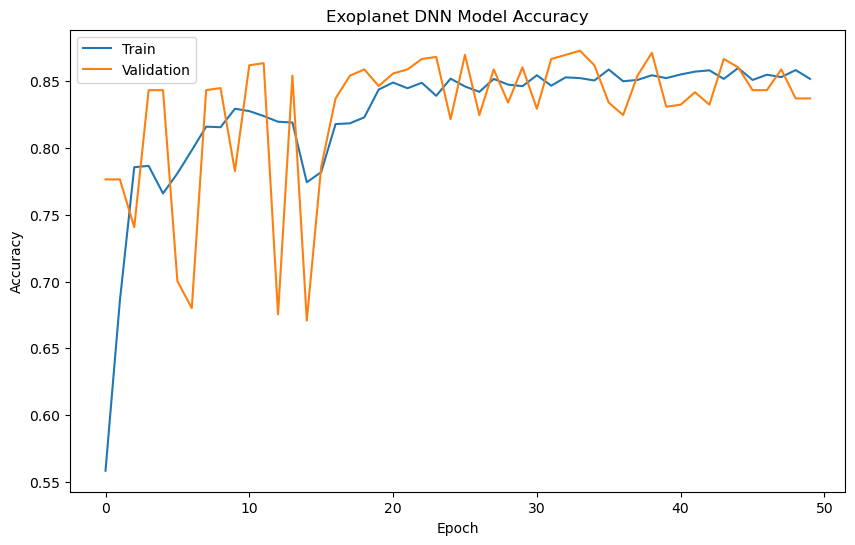

In [18]:
plt.figure(figsize=(10,6))

# training accuracy over epochs
plt.plot(best_dnn_model.history['accuracy'])

# validation accuracy over epochs
plt.plot(best_dnn_model.history['val_accuracy'])

plt.title('Exoplanet DNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

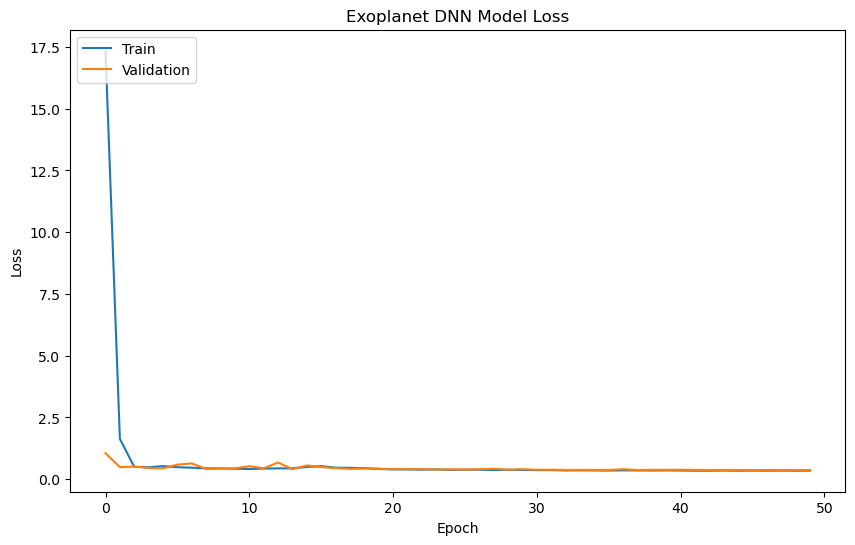

In [19]:
# Display loss separately 
# Loss is a fundamental measure of how well a machine learning model's predictions match the actual outcomes
# Loss quantifies the difference between pred values and actual values 
# Goal of training a model is to MINIMIZE LOSS
# By minimizing loss we can improve the model's accuracy and predictive power
# Loss guides hyperparamter tuning

plt.figure(figsize=(10,6))

# training loss over epochs
plt.plot(best_dnn_model.history['loss'])

# validation loss over epochs
plt.plot(best_dnn_model.history['val_loss'])

plt.title('Exoplanet DNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# DNN Feature Importance 

In [20]:
# get weights from the input layer
weights = best_dnn.layers[0].get_weights()[0]

# calculate importance of each feature
feature_importance = np.sum(np.abs(weights), axis=1)

# normalize
feature_importance /= np.sum(feature_importance)

## Make it into a df

In [21]:
feature_names = features.keys()
feature_weights_df = pd.DataFrame({'Feature': feature_names, 'Normalized Weight': feature_importance})

feature_weights_df = feature_weights_df.sort_values(by='Normalized Weight', ascending=False)
feature_weights_df

,Feature,Normalized Weight
6,Number of Photometry Time Series,0.252339
4,Ecliptic Latitude [deg],0.216743
5,Ecliptic Longitude [deg],0.168281
3,Galactic Longitude [deg],0.078873
1,Number of Planets,0.071416
0,Number of Stars,0.064203
2,Galactic Latitude [deg],0.059591
8,Number of Transmission Spectroscopy Measurements,0.051281
7,Number of Emission Spectroscopy Measurements,0.025976
9,Discovery Year,0.011297


## Plot features and weights

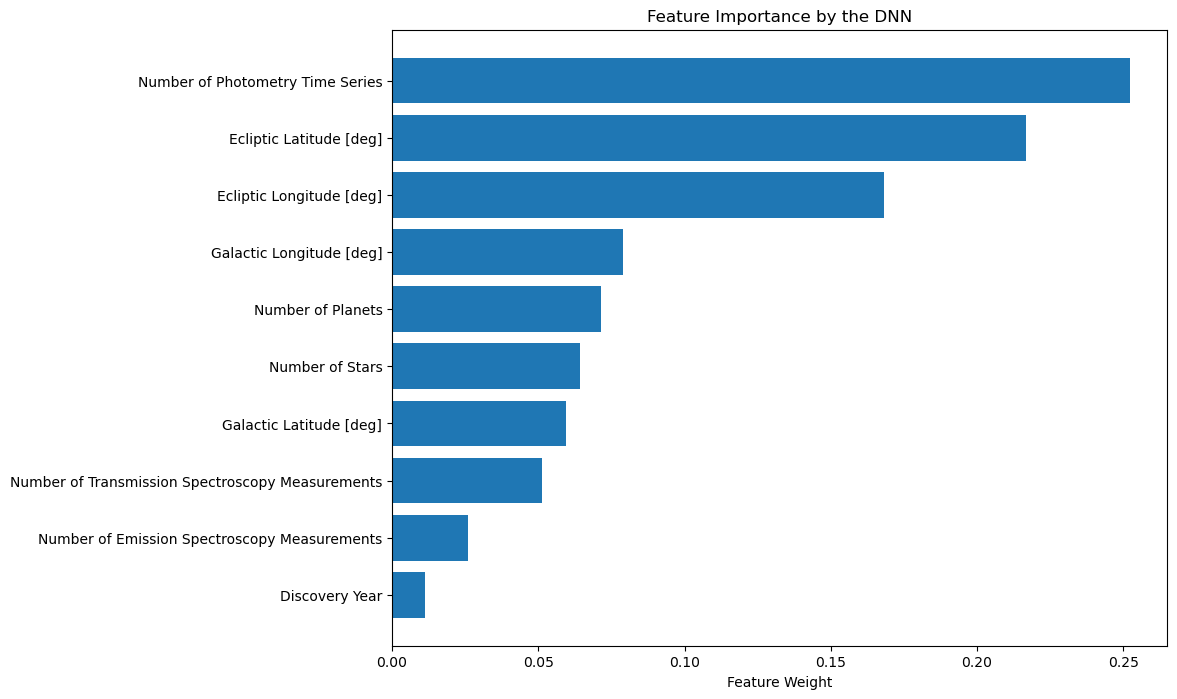

In [22]:
plt.figure(figsize=(10,8))
plt.barh(feature_weights_df['Feature'], feature_weights_df['Normalized Weight'])
plt.xlabel('Feature Weight')
plt.title('Feature Importance by the DNN')
plt.gca().invert_yaxis()
plt.show()

# Save the trained model for future use

In [23]:
# saves model to hdf5 file
# best_dnn_model.save('best_exopldm_model.h5')